In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *

from matplotlib import rc
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2

np.set_printoptions(suppress=True, precision = 4)

from scipy.special import gammainc
from scipy.stats import norm

def sig(x):
    return 1.0/(1.0 + np.exp(-x))

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def create_linear_track(L):
    G = nx.DiGraph()
    G.add_nodes_from([('0')])
    G.add_nodes_from([(str(L))])
    for l in range(1,L):
        G.add_nodes_from([(str(l))])
        G.add_nodes_from([(str(l)+'b')])
    index = 0
    for l in range(L):
        G.add_edges_from([(str(l),str(l+1),{'Qe':0, 'Qr':0, 'V':0, 'R':0, 'i':index}),(str(l+1),str(l),{'Qe':0, 'Qr':0, 'V':0,'R':0, 'i':index+1})])
        index += 2
        
    for l in range(1,L):
        G.add_edges_from([(str(l)+'b',str(l),{'Qe':0, 'Qr':0, 'V':0, 'R':0, 'i':index}),(str(l),str(l)+'b',{'Qe':0, 'Qr':0, 'V':0,'R':0, 'i':index+1})])
        index += 2
    
    return G

def get_transition_matrix_linear(L): 
    G = create_linear_track(L)
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2 
    #if on main branch, a= 0 continue along main branch, a = 1 branch out
    #if coming out of branch, a = 0 go towards start, a = 1 go towards goal
    #if going into branch, you come out regardless. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
                n3 = deepcopy(n1)
            elif n1[-1] == 'b': #coming out of branch
                n3 = str(int(n2) - 1 + 2*a)
            elif int(n2) > int(n1): #going towards goal on main branch
                if a == 0:
                    n3 = str(int(n2) + 1)
                if a == 1:
                    n3 = n2 + 'b'
            elif int(n2) < int(n1): #going towards start on main branch
                if a == 0:
                    n3 = str(int(n2) - 1)
                if a == 1:
                    n3 = n2 + 'b'
                    
            nextstate = (n2,n3)
            
            #print(a,n1,n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat

def initialize_Q(G,eps,eps2): #set exploration probabilities via Qe
    p_d = 1.0/(1.0 + np.exp(-eps)) #prob of continuing towards goal when going towards goal on main branch
    p_u = 0.5 #prob of continuing towards start when going towards start on main branch
    r_u = 1.0/(1.0 + np.exp(eps2)) #prob of going towards start when coming out of branch
    
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2 
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'][1] = 0
        eps = 0
        
        if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
            eps = 0
        elif n1[-1] == 'b': #coming out of branch
            eps = np.log(r_u/(1-r_u))
        elif int(n2) > int(n1):#going towards goal on main branch
            eps = np.log(p_d/(1-p_d))
        elif int(n2) < int(n1):#going towards start on main branch
            eps = np.log(p_u/(1-p_u))  
                
        G[state[0]][state[1]]['Qe'][0] = eps
        
    return G

def get_pp_pn(eps,eps2,eps3):
    pp = sig(eps) + (1-sig(eps))*sig(eps2)
    pn = sig(eps3) + (1-sig(eps3))*(1-sig(eps2))
    return pp,pn
    
def get_qs_numerics(r,L,N,eps,eps2, alpha = 0.05, gam = 1-1e-5):
    qs = np.zeros((L,N))
    qs[-1] = r

    ss = np.zeros((L,N))

    qst = np.zeros(L)
    qst[-1] = r

    for i in range(1,L):
        qst[:-1] = gam*sig(eps+qst[1:])*qst[1:]

    for n in range(1,N):
        sigq = sig(eps+qs[:-1,n-1])
        sigs = sig(eps2+ss[:-1,n-1])

        rho =  sigq/((1-sigq)*sigs + sigq)

        qs[:-1,n] = qs[:-1,n-1] + alpha*(-qs[:-1,n-1] + gam*qs[1:,n-1]*sig(eps+qs[1:,n-1]))*rho
        ss[:-1,n] = ss[:-1,n-1] + alpha*(-ss[:-1,n-1] + gam*qs[1:,n-1]*sig(eps+qs[1:,n-1]))*(1-rho)
    return qs,ss
    
    
def get_speed_pred(L,eps,eps2,r):
    s = sig(eps2)
    qthr = r
    if eps <= 0:
        v = r/(qthr + np.exp(-eps)*(1 - np.exp(-qthr))*s)
    else:
        v = 1
    return min(1,v)

def get_speed_numerics(L,eps,eps2,r,alpha = 0.01,gam = 1 - 1e-5, plot =False):
    vest = sig(eps + np.log(r))*alpha
    N = int(1.05*L/vest)

    qs,ss = get_qs_numerics(r,L,N,eps,eps2,alpha = alpha, gam = gam)

    mins = np.argmin(np.abs(qs - np.max(qs,axis=0)[None,:]/2),axis=0)
    p = np.polyfit(np.arange(len(mins[int(0.1*N):-int(0.1*N)])),mins[int(0.1*N):-int(0.1*N)],1)
    if plot:
        plt.close("all")
        fig,axis = plt.subplots(1,1,figsize = (3,3))
        axis.plot(np.arange(len(mins[int(0.1*N):-int(0.1*N)])),mins[int(0.1*N):-int(0.1*N)])
        axis.plot(L-1 - alpha*np.arange(N))

        axis.plot(p[0]*np.arange(len(mins[int(0.1*N):-int(0.1*N)])) + p[1])
        plt.show()

    return -p[0]/alpha

def get_speed_sarsa(L,eps,eps2,r,alpha = 0.1,gam = 1 - 1e-5, q_mem_size = 1, plot = False):
    # Learning parameters
    
    rew = r
    if q_mem_size <= 1:
        lamb = 0
    else:
        lamb = 1

    niter = 50000
    nepi = int(8*L/alpha)
    
    G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                        alpha = alpha,gam=gam,rew = rew, mode=2, eps = eps, eps2=eps2, q_mem_size = q_mem_size)
    
    nepi = len(Qrs)
    mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)

    #print(mins)
    p = np.polyfit(np.arange(len(mins[:])),mins[:],1)
    if plot:
        plt.close("all")
        plt.plot(mins)
        plt.plot(L-1 - alpha*np.arange(len(mins)))

        plt.plot(p[0]*np.arange(len(mins[:])) + p[1])
        plt.show()
    return -p[0]/alpha

In [4]:
def set_Q_BCs(G):
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        eps = 0
        if n2[-1] == 'b' or n2 == str(L) or n2 == str(0): #reflecting BC
            G[n1][n2]['Qr'] = np.zeros(A)
        elif n1[-1] == 'b': #coming out of branch
            True
        elif int(n2) > int(n1):#going towards goal on main branch
            G[n1][n2]['Qr'][1] = 0
        elif int(n2) < int(n1):#going towards start on main branch
            G[n1][n2]['Qr'][1] = 0
    return G
        
    
def get_Qvalues(G,L):
    Qrs = np.zeros((L-1,2,2))
    for i in range(L-1):
        Qrs[i,:,0] = G[str(i)][str(i+1)]['Qr']
        Qrs[i,:,1] = G[str(i+1)+'b'][str(i+1)]['Qr']
        
    Qes = np.zeros((L-1,2,2))
    for i in range(L-1):
        Qes[i,:,0] = G[str(i)][str(i+1)]['Qe']
        Qes[i,:,1] = G[str(i+1)+'b'][str(i+1)]['Qe']
        
    return Qrs, Qes

def run_RL_simulation(nepi,niter,L, alpha = 0.01, gam = 0.98,lamb = 0.8, goal = ('2','3'),\
                     rew = 20,mode = 0, eps = 0, eps2= 0, q_mem_size = None, dyna_mem_size = 500,\
                      auto_stop = True, dyna_plan_steps = 10):
    #Initialize setup

    #generate graph and get Q values
    G = create_linear_track(L)
    Tmat = get_transition_matrix_linear(L)
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = 2

    G = initialize_Q(G,eps,eps2)
    
    goal = (str(L-1),str(L))

    #initialize environment

    rew_timer = 0
    G[goal[0]][goal[1]]['R'] = rew

    nodes = ['0']
    
    if q_mem_size is None:
        q_mem_size = int(2.5/(1-lamb))

    rews_received = 0
    cum_rews = []
    time_rews = []
    
    params = [alpha,gam,lamb]
    
    dyna_mem = []
    
    Qr_stored = np.zeros((nepi,L-1,2,2))

    for epi in range(nepi):
        #initialize state
        n0 = str(0)
        n1 = str(1)
        state = (n0,n1) 

        nodes += [state[1]]

        q_mem = []

        
        G = set_Q_BCs(G)
        
        for i in range(niter):
            rew_timer += 1
            s_index = get_state_index(state,G)
            a = get_action(state,G)
            #a=0
            s_next = get_next_state(s_index,a,Tmat)
            prevstate = deepcopy(state)
            state = index_to_state[s_next]
            curr_rew = G[state[0]][state[1]]['R']

            nodes += [state[1]]
            
            sasr = [prevstate, a, state, curr_rew]
            
            if mode == 3:
                dyna_mem = update_memory_dyna(dyna_mem, sasr, dyna_mem_size)
            else:
                q_mem = update_memory_q(q_mem, sasr, q_mem_size)
            
            if mode == 0:
                G = update_Q_sQ(q_mem,sasr,goal,G,params) #sQ
            elif mode == 1:
                G = update_Q_Q(q_mem,sasr,goal,G,params) #Q
            elif mode == 2:
                G = update_Q_sarsa(q_mem,sasr,goal,G,params) #sarsa
            elif mode == 3:
                G = update_Q_dyna(dyna_mem,sasr,goal,G,params)
            
            
            #print("%03d   %03d   " %(epi, i), state[0],state[-1])

            if state == goal:
                rews_received += 1
                cum_rews += [rews_received]
                time_rews += [rew_timer] 
                break
                
        Qr_stored[epi] = get_Qvalues(G,L)[0]
        if G['0']['1']['Qr'][0] > rew*0.5 and auto_stop:
            nepi = epi+1
            Qr_stored = Qr_stored[:nepi]
            break
    return G, Qr_stored, time_rews, cum_rews
        
def get_direct_paths(time_rews,L):
    time_paths = [0]
    cum_paths = [0]
    for i in range(len(time_rews)-1):
        dt = time_rews[i+1] -  time_rews[i]
        if dt == L-1:
            time_paths += [time_rews[i+1]]
            cum_paths += [cum_paths[-1] + 1]
    return time_paths, cum_paths

### Run RL simulation on linear track (SARSA)

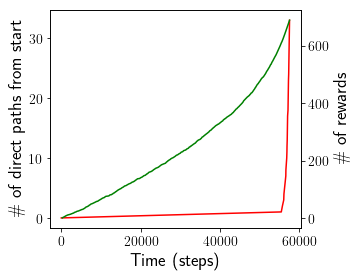

688
nepi: 688  vsim:  0.68  vnum:  0.69 


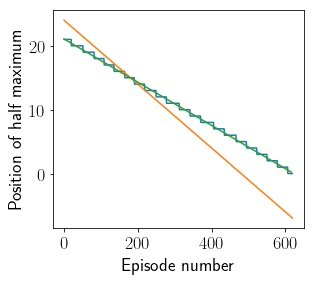

In [5]:
np.random.seed(0)
# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
rew = 8
eps = -1
eps2 = 1
L = 25 #length of track
lamb = 0.0 #eligibility traces

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(4*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                    alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2)
time_paths, cum_paths = get_direct_paths(time_rews,L)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 14)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-')
ax.tick_params(labelsize = 14)
axis.plot(time_paths, cum_paths,'r-')
axis.set_ylabel("\# of direct paths from start", fontsize= 18)
ax.set_ylabel("\# of rewards", fontsize= 18)
axis.set_xlabel("Time (steps)", fontsize= 18)
plt.show()

#Measure speed of wave.
#This tracks the position of the half maximum of the reward after each episode.  

nepi = len(Qrs)
print(nepi)
mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
vsim = -p[0]/alpha

#Prediction from numerics as a consistency check
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,plot = False)
print("nepi: %d  vsim:  %.2f  vnum:  %.2f "%(nepi, vsim, vnum))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.plot(mins)
axis.plot(L-1 - alpha*np.arange(len(mins))) #speed of 1. 
axis.plot(p[0]*np.arange(len(mins[3:])) + p[1])
axis.set_xlabel("Episode number",fontsize = 18)
axis.set_ylabel("Position of half maximum",fontsize = 18)
axis.tick_params(labelsize = 18)
plt.show()

### Plot the q_n and q_n' during learning (RL simulations)

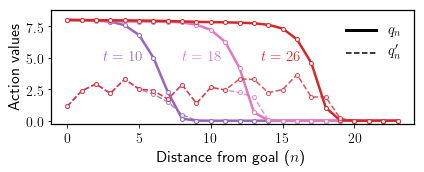

In [16]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,2.5))
epis = [int(10/alpha),int(18/alpha),int(26/alpha)]
colors = ['C4','C6','C3']
alphas = [1,1,1]
locs = [L-22.5,L-17,L-11.5]



for i,e in enumerate(epis):
    axis.plot(Qrs[e,-1::-1,0,0],'o-',lw = 2.5,ms = 4, mec=colors[i],mfc = 'w', color = colors[i],alpha = alphas[i])
    axis.plot(Qrs[e,-1::-1,1,1], 'o--', lw = 1.5,ms = 4,mec=colors[i],mfc = 'w', color = colors[i],alpha = 0.8)
    
    axis.text(locs[i],0.6*rew,r"$t = %d$"%(e*alpha),color = colors[i],fontsize = 15)
    
axis.plot([],[],'k-',lw=3,label = r"$q_n$")
axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
axis.legend(fontsize = 15,frameon=False)

#axis.set_title("Episode: %d"%i,fontsize= 15)
axis.tick_params(labelsize = 14)
axis.set_ylim(-0.25,np.max(Qrs)*1.1)
axis.set_xlabel(r"Distance from goal ($n$)",fontsize = 16)
axis.set_ylabel(r"Action values",fontsize= 16)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
    
fig.tight_layout()
fig.savefig("./plots/wave_simulations_only.pdf")
plt.show()

### Generate plots for movies 

#### Run simulation

In [143]:
np.random.seed(0)
# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
rew = 8
eps = -1
eps2 = 1
L = 40 #length of track
lamb = 0.0 #eligibility traces

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = 1500 #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                    alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, auto_stop = False)
time_paths, cum_paths = get_direct_paths(time_rews,L)

cum_paths_by_epi = [0]
for i in range(1,len(time_rews)):
    if time_rews[i] in time_paths:
        cum_paths_by_epi += [cum_paths_by_epi[-1] + 1]
    else:
        cum_paths_by_epi += [cum_paths_by_epi[-1]]
        
    #print(i,time_rews[i], cum_paths_by_epi[-1])


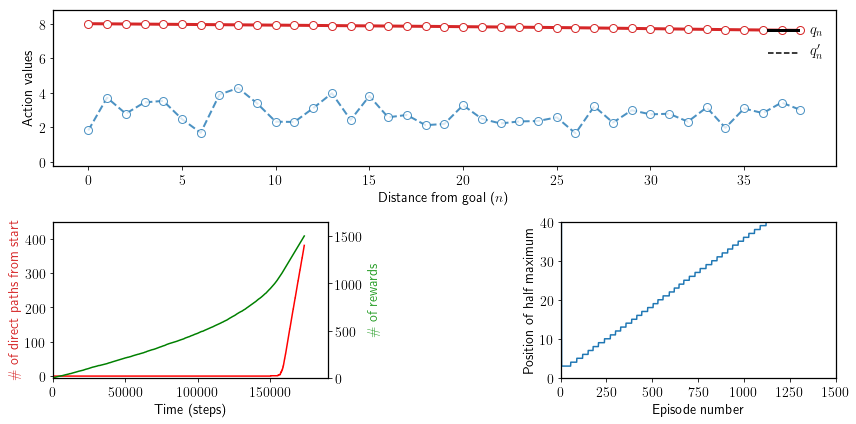

In [145]:
for i in range(1,len(Qrs),2):
    plt.close("all")

    fig = plt.figure(figsize = (12,6))
    axis = fig.add_subplot(2,5,(1,5))

    ax1 = fig.add_subplot(2,5,(6,7))
    ax2 = fig.add_subplot(2,5,(9,10))

    #axis

    axis.plot(Qrs[i,-1::-1,0,0],'C3o-',lw = 3,ms = 8, mec='C3',mfc = 'w')
    axis.plot(Qrs[i,-1::-1,1,1], 'C0o--', lw = 2,ms = 8,mec='C0',mfc = 'w',alpha = 0.8)
    axis.plot([],[],'k-',lw=3,label = r"$q_n$")
    axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
    axis.legend(fontsize = 15,frameon=False, loc = 1)

    #axis.set_title("Episode: %d"%i,fontsize= 15)
    axis.tick_params(labelsize = 14)
    axis.set_ylim(-0.25,np.max(Qrs)*1.1)
    axis.set_xlabel(r"Distance from goal ($n$)",fontsize = 14)
    axis.set_ylabel(r"Action values",fontsize= 14)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.25)

    #ax2
    mins = np.argmin(np.abs(Qrs[5:i,:,0,0] - np.max(Qrs[5:i,:,0,0],axis=1)[:,None]/2),axis=1)
    ax2.plot(L-mins)
    ax2.set_xlabel("Episode number",fontsize = 14)
    ax2.set_ylabel("Position of half maximum",fontsize = 14)
    ax2.tick_params(labelsize = 14)
    ax2.set_xlim(0,nepi)
    ax2.set_ylim(0,L)
    for sp in ['top','bottom','left','right']:
        ax2.spines[sp].set_linewidth(1.25)

    #ax1
    ax1.tick_params(labelsize = 14)
    ax = ax1.twinx()
    ax.plot(time_rews[1:i], cum_rews[1:i],'g-')
    ax.tick_params(labelsize = 14)
    ax1.plot(time_rews[1:i], cum_paths_by_epi[1:i],'r-')
    ax1.set_xlim(0,190000)
    ax1.set_ylim(-5,450)
    ax.set_ylim(0,nepi*1.1)
    ax1.set_ylabel("\# of direct paths from start", fontsize= 14, color = 'C3')
    ax.set_ylabel("\# of rewards", fontsize= 14, color = 'C2')
    ax1.set_xlabel("Time (steps)", fontsize= 14)
    for sp in ['top','bottom','left','right']:
        ax1.spines[sp].set_linewidth(1.25)

    fig.tight_layout()
    fig.savefig("./movies/movie_r8_L40_%04d.png"%i, dpi = 150)
#plt.show()

### run simulation for marching regime movie

In [169]:
np.random.seed(0)
# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
rew = 10
eps = -2
eps2 = 1
L = 40 #length of track
lamb = 0.0 #eligibility traces

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = 1500 #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                    alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2, auto_stop = False)
time_paths, cum_paths = get_direct_paths(time_rews,L)

cum_paths_by_epi = [0]
for i in range(1,len(time_rews)):
    if time_rews[i] in time_paths:
        cum_paths_by_epi += [cum_paths_by_epi[-1] + 1]
    else:
        cum_paths_by_epi += [cum_paths_by_epi[-1]]
        
    #print(i,time_rews[i], cum_paths_by_epi[-1])



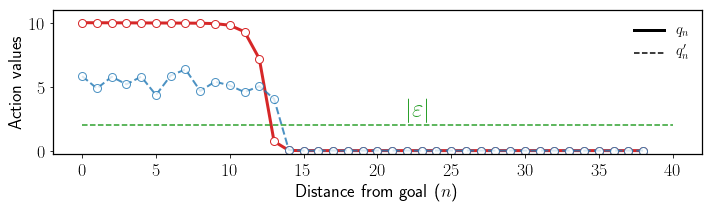

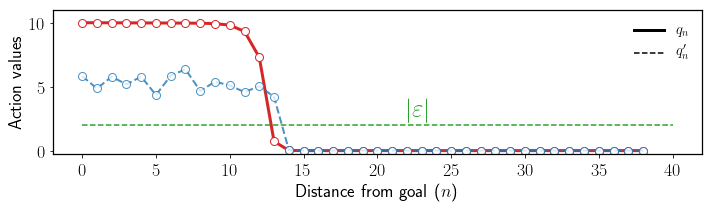

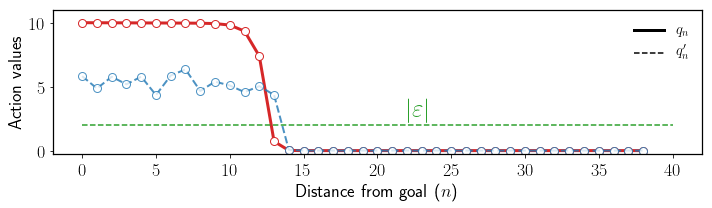

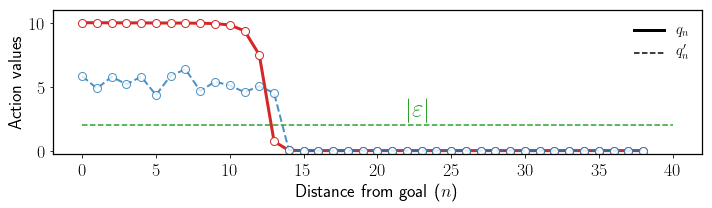

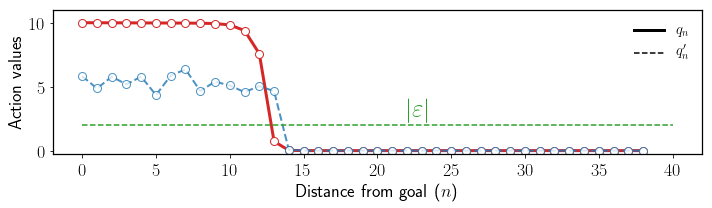

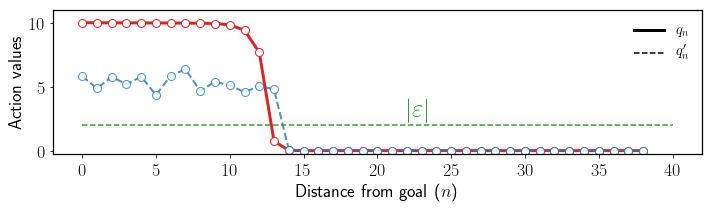

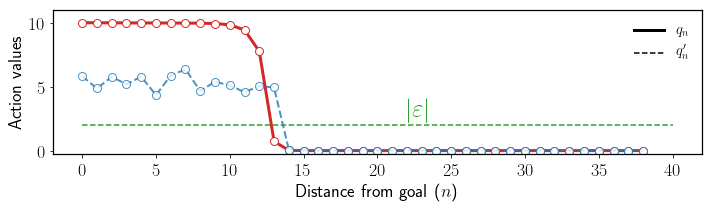

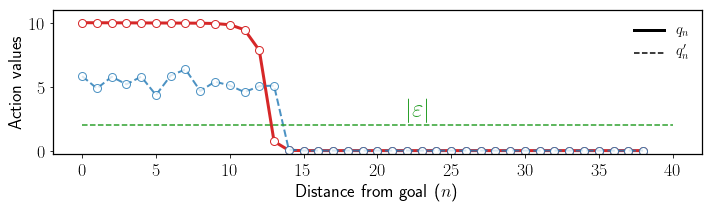

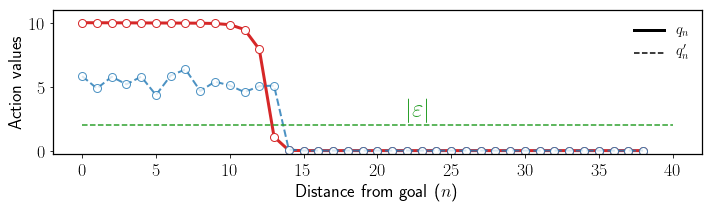

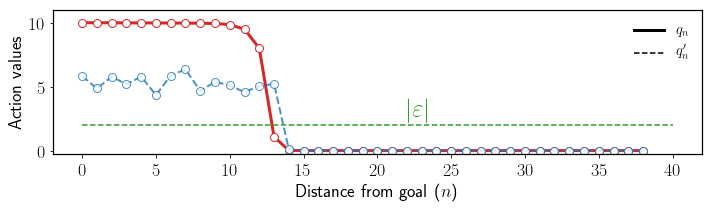

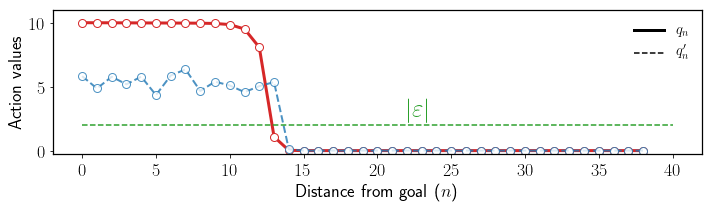

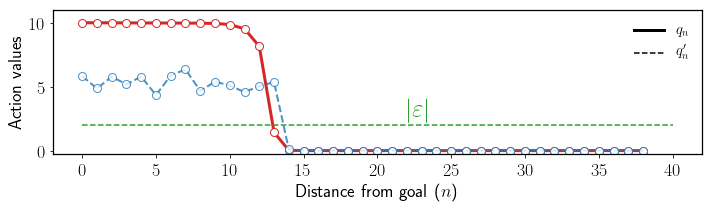

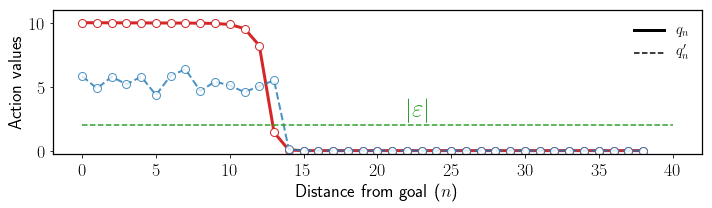

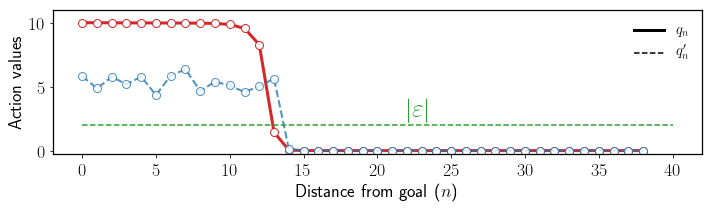

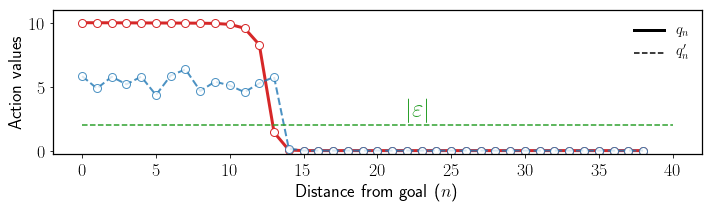

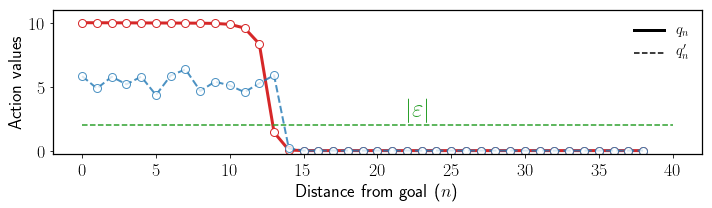

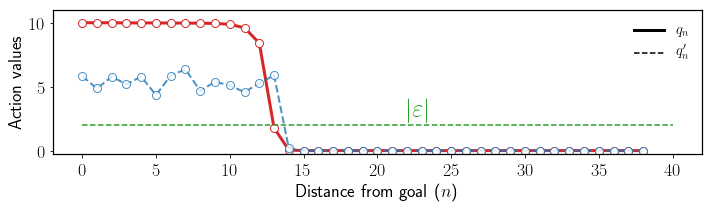

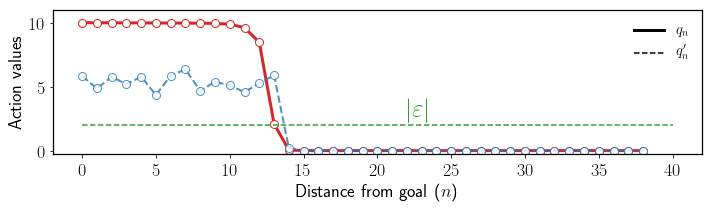

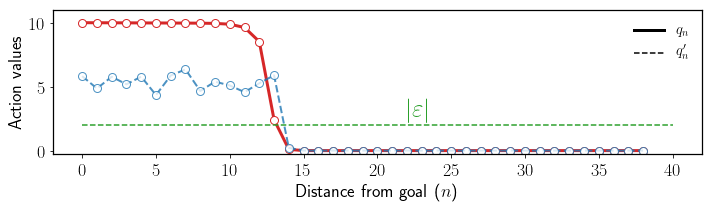

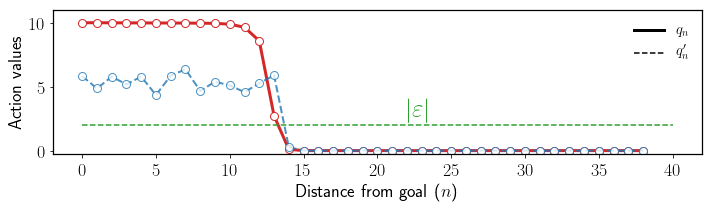

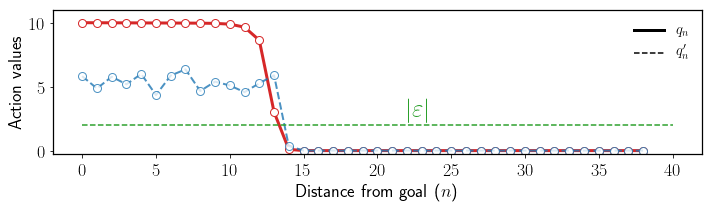

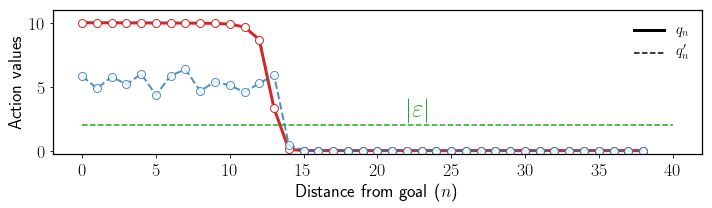

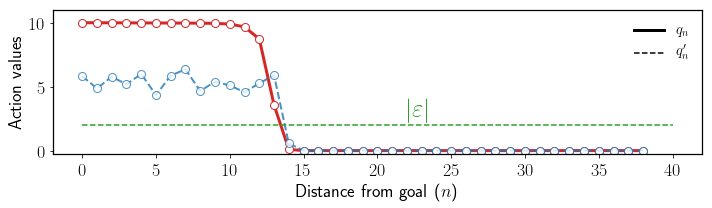

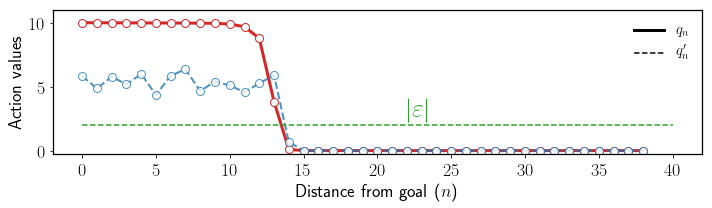

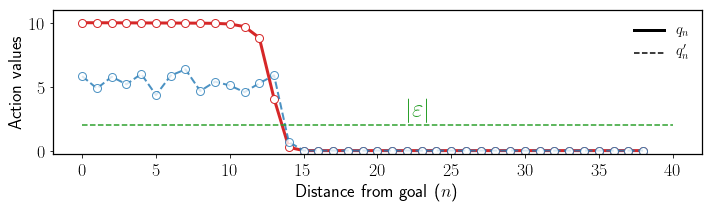

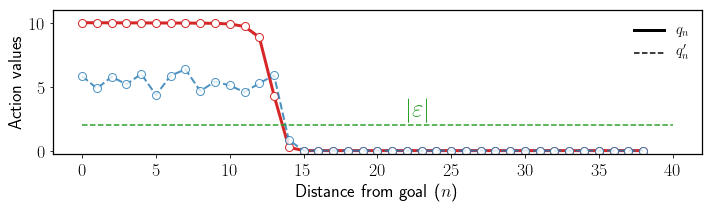

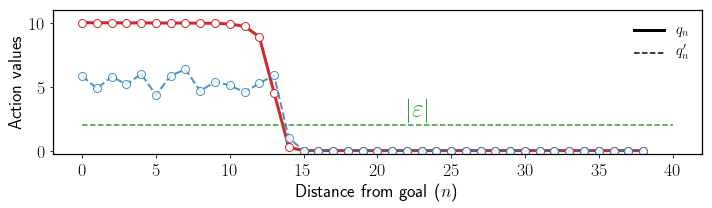

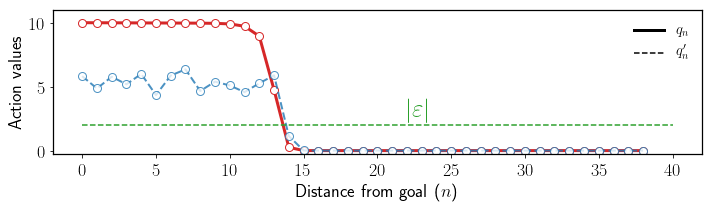

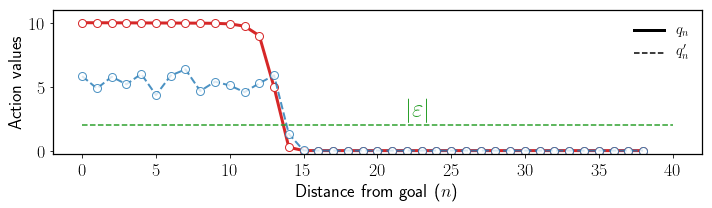

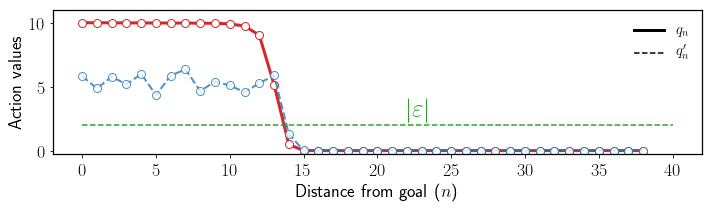

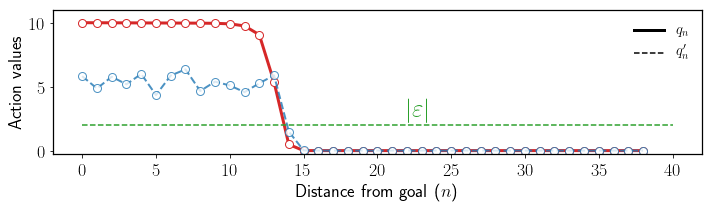

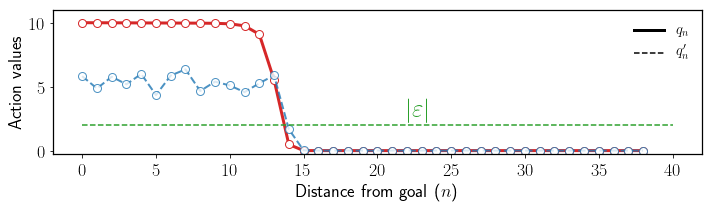

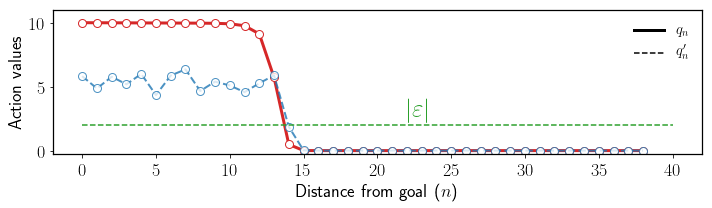

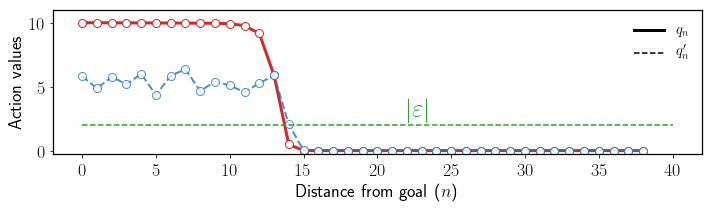

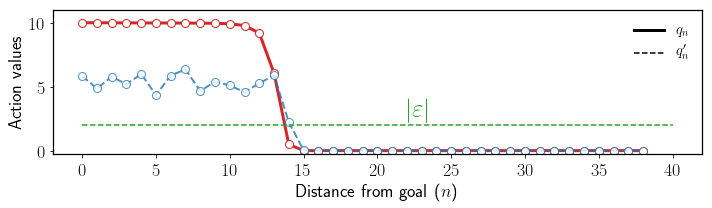

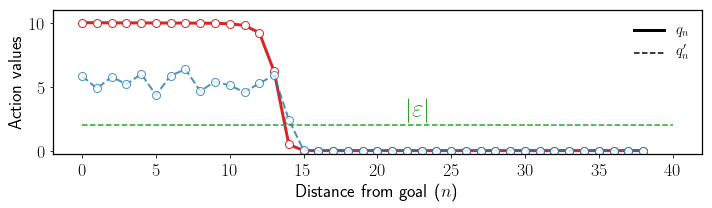

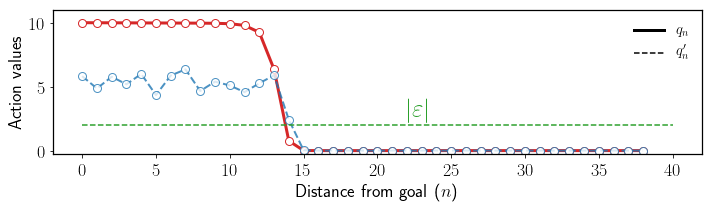

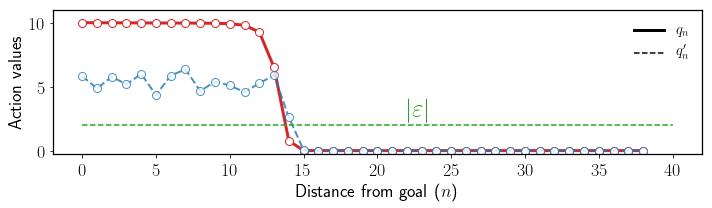

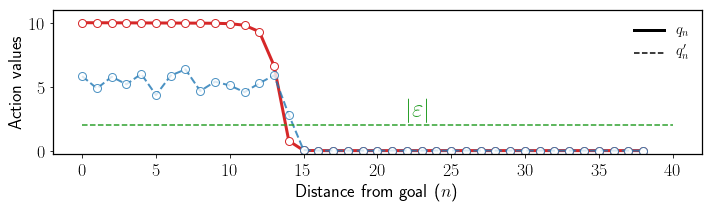

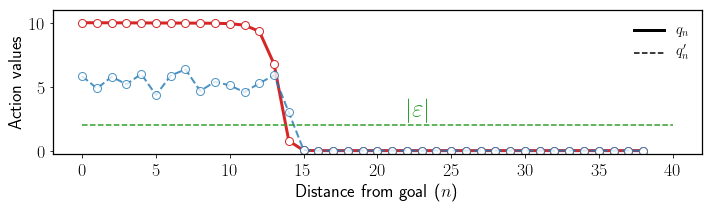

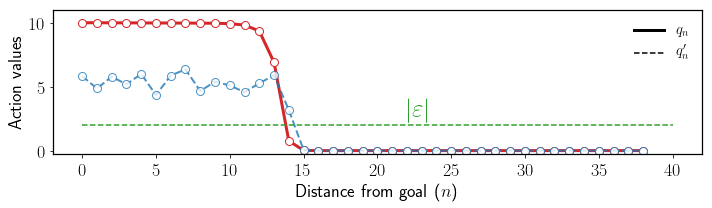

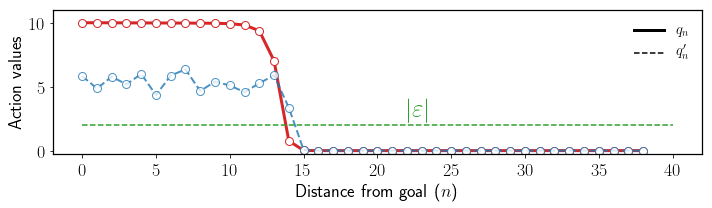

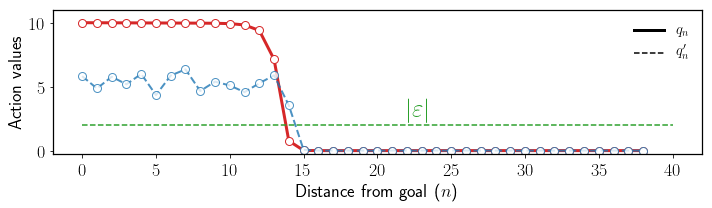

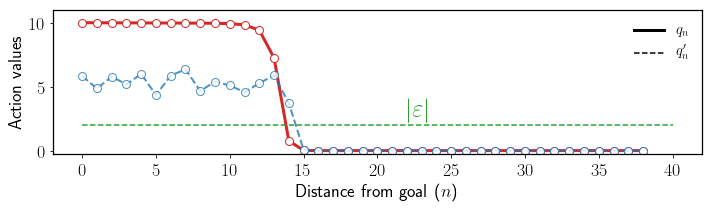

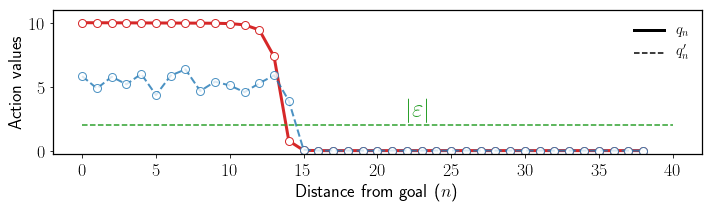

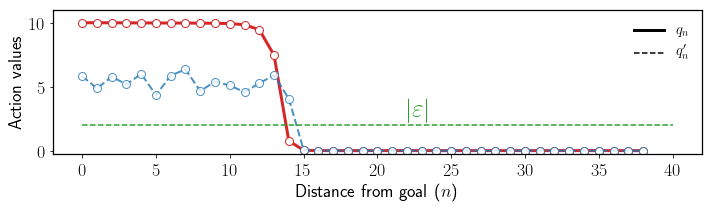

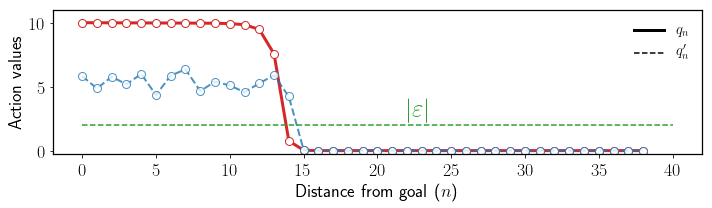

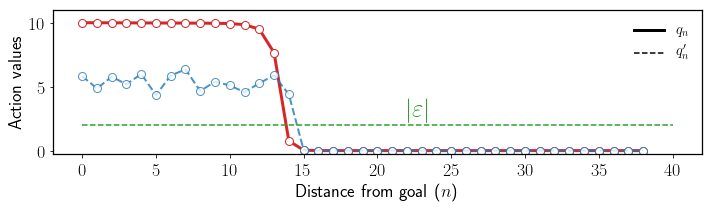

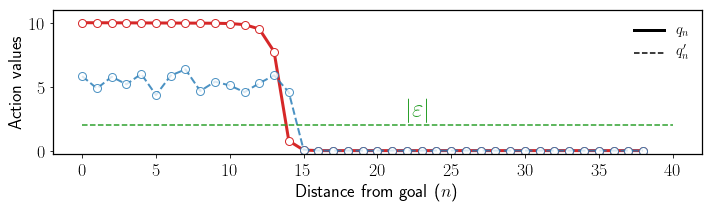

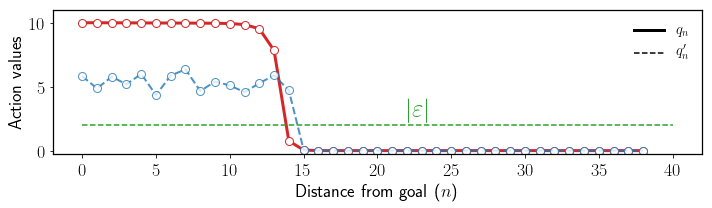

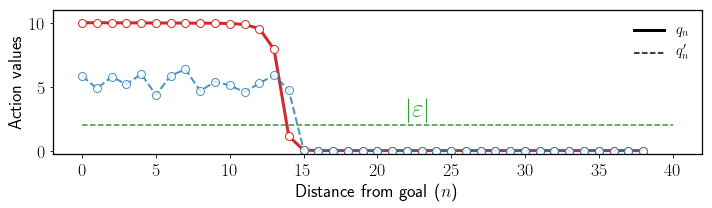

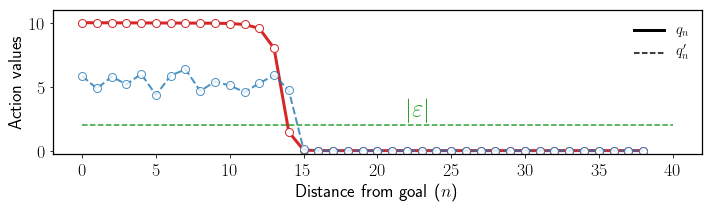

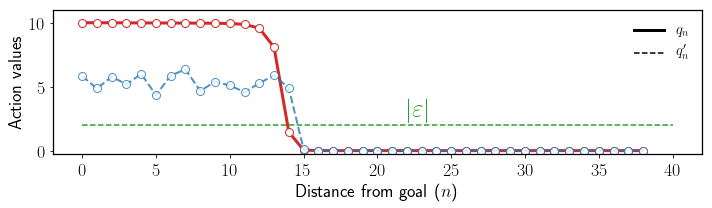

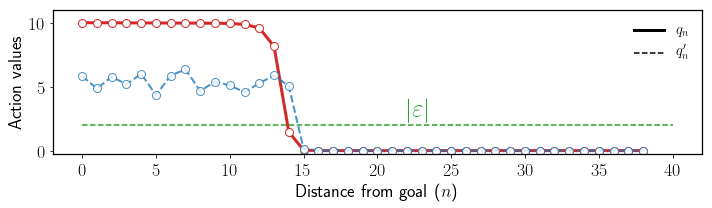

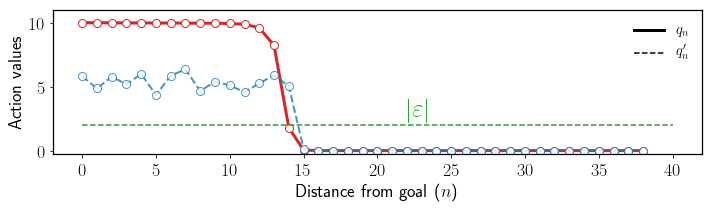

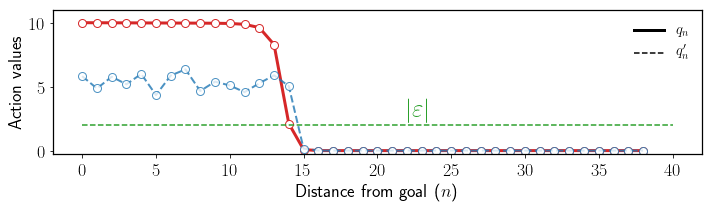

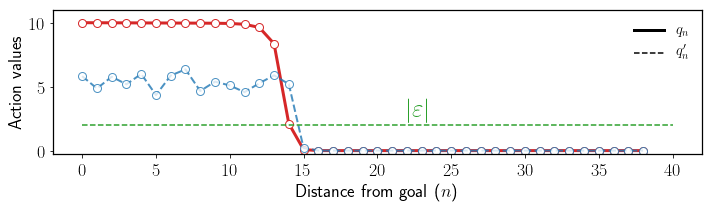

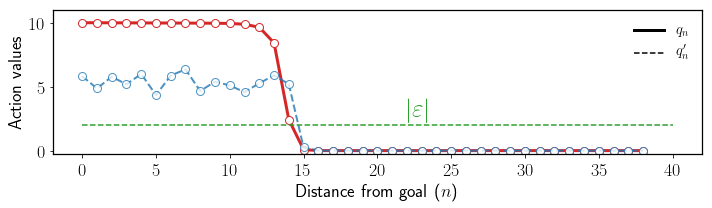

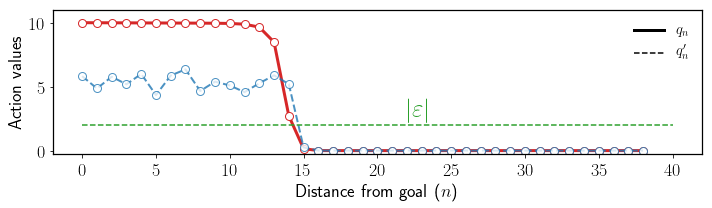

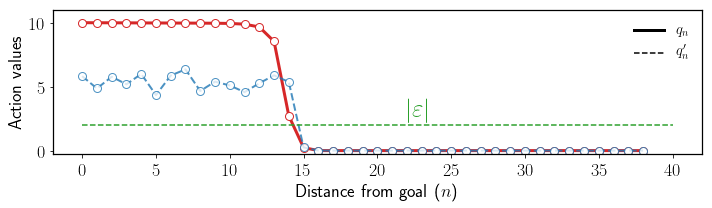

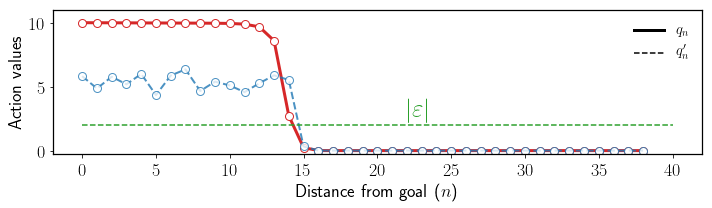

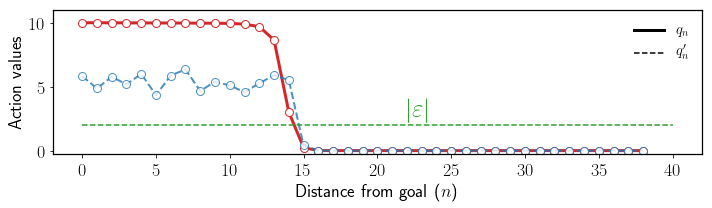

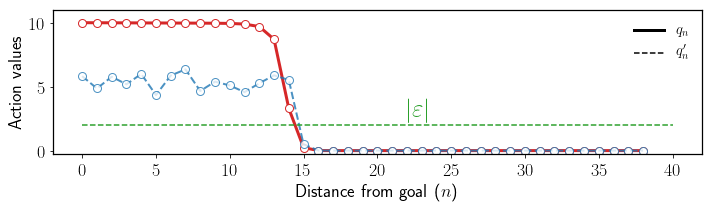

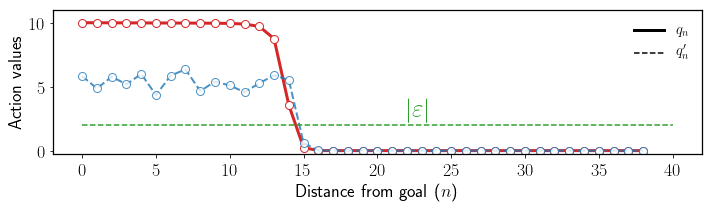

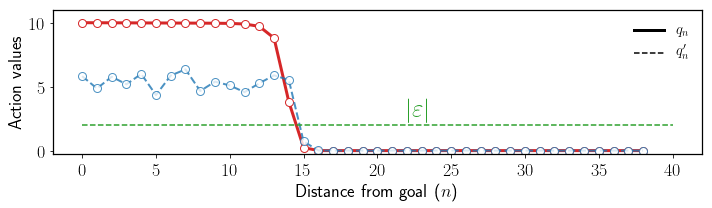

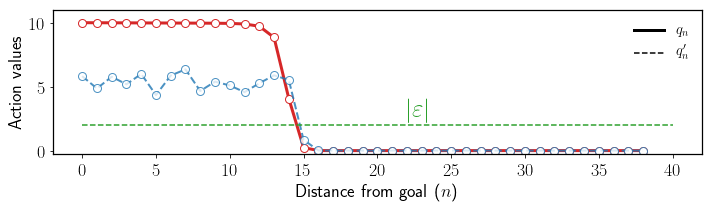

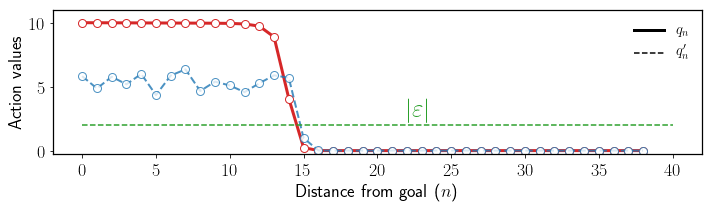

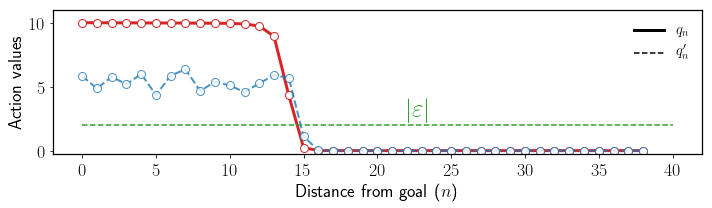

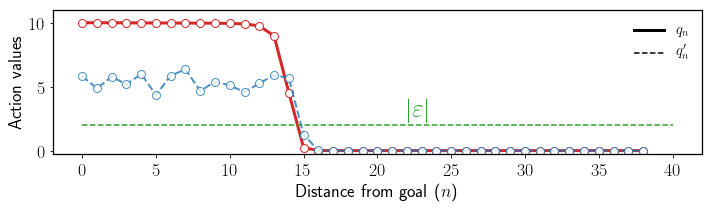

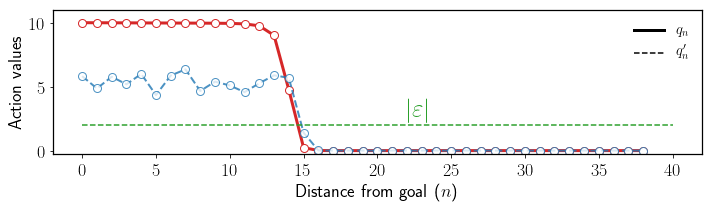

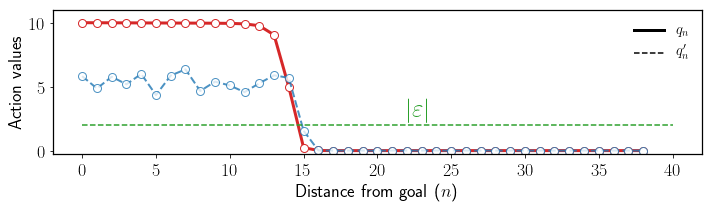

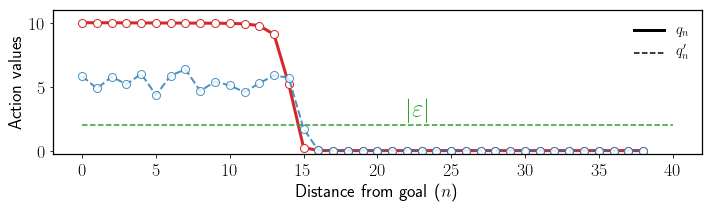

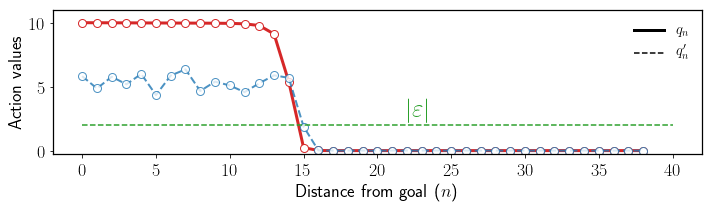

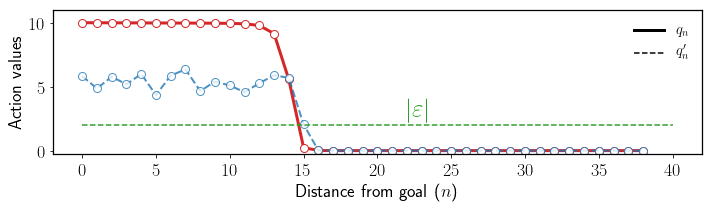

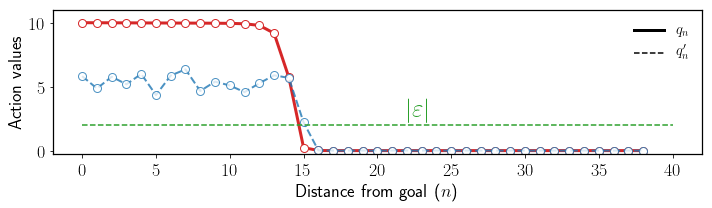

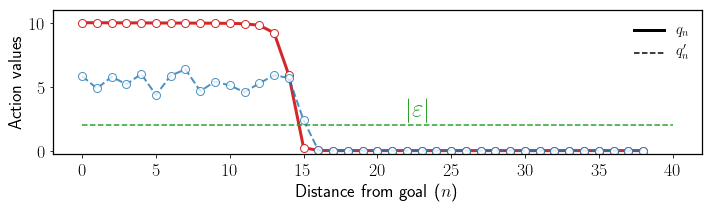

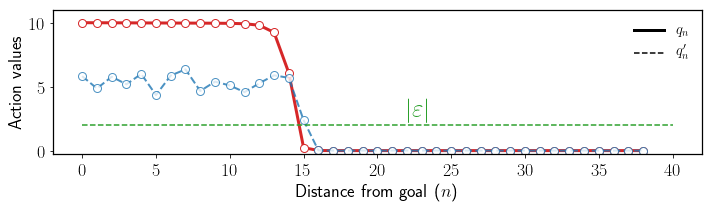

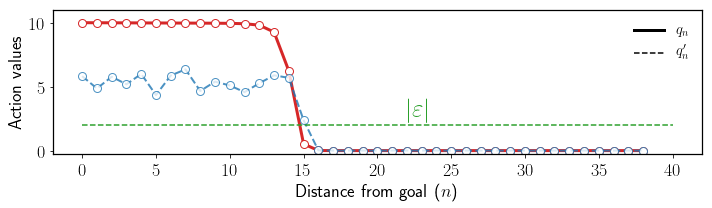

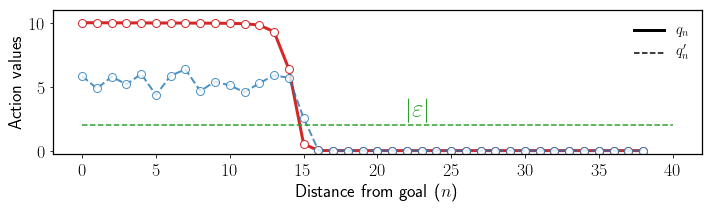

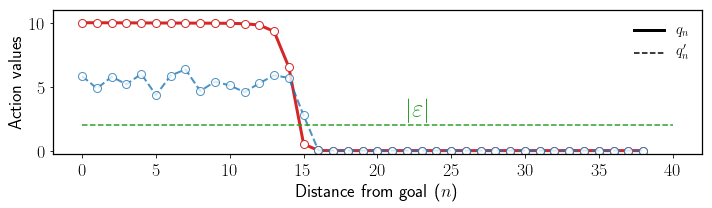

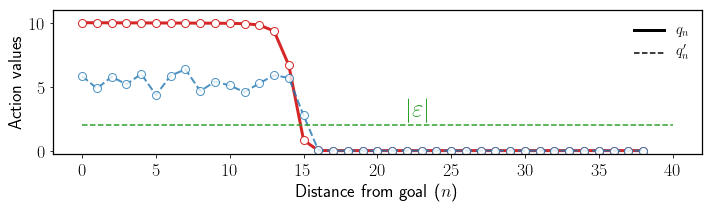

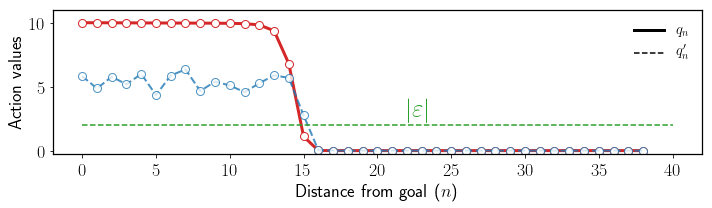

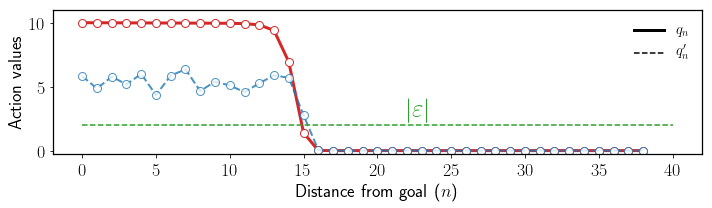

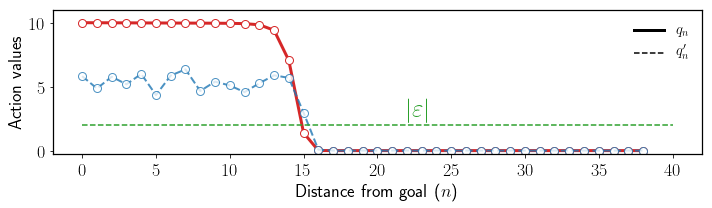

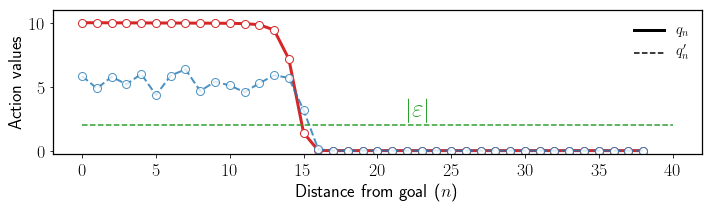

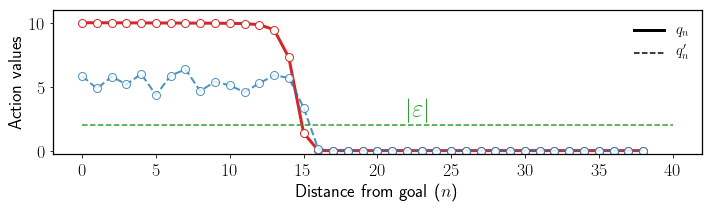

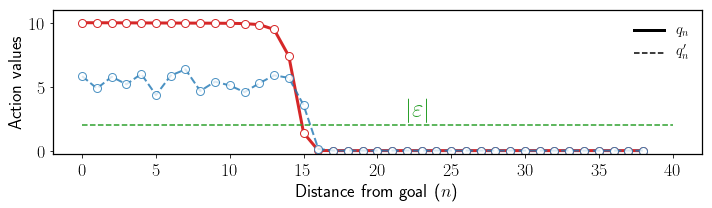

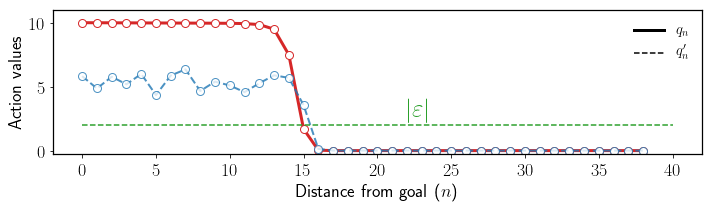

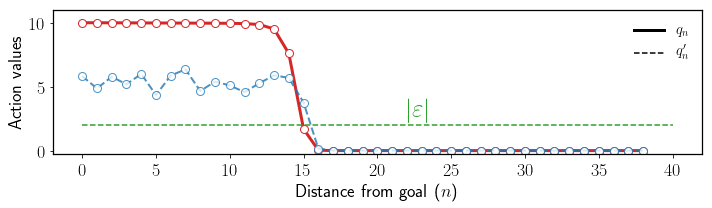

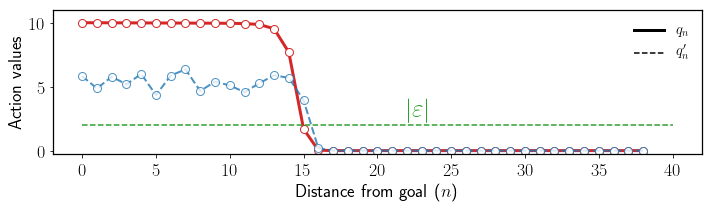

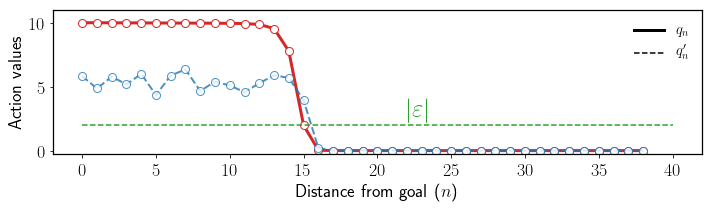

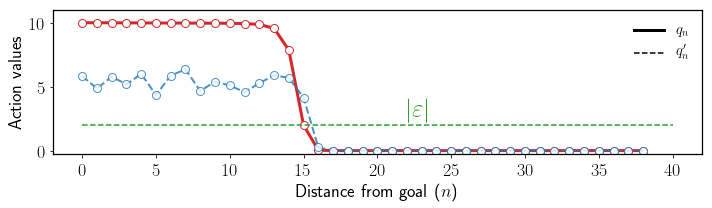

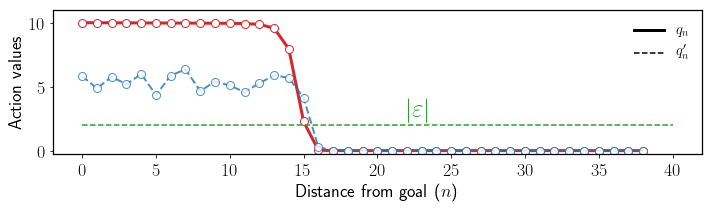

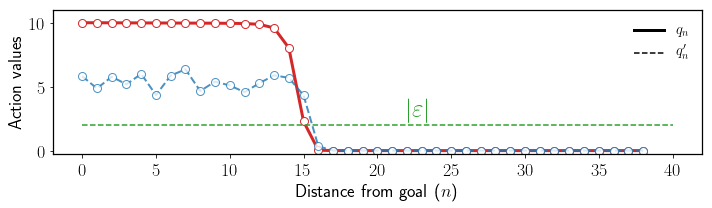

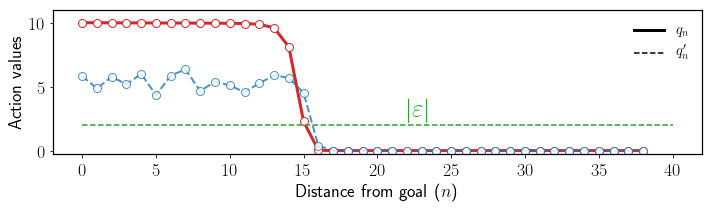

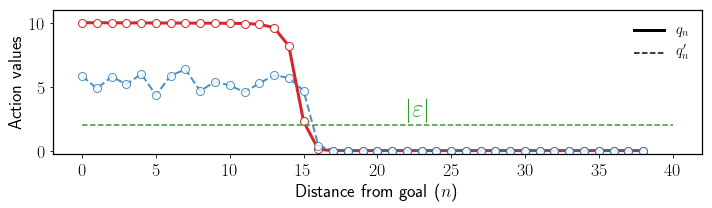

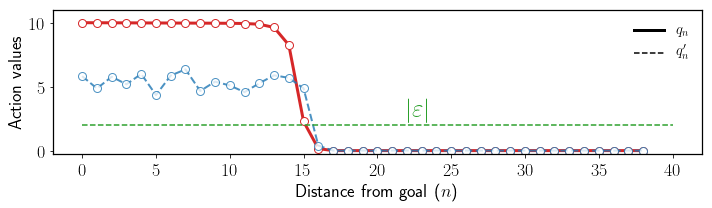

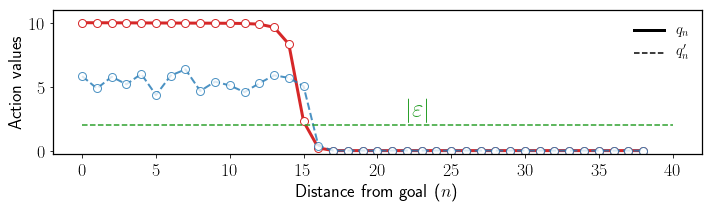

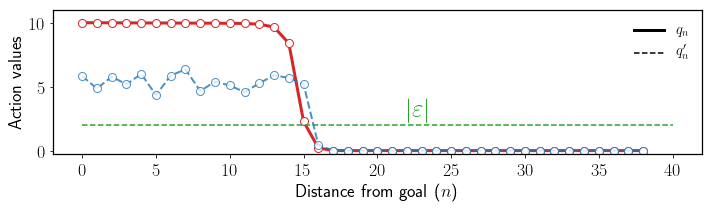

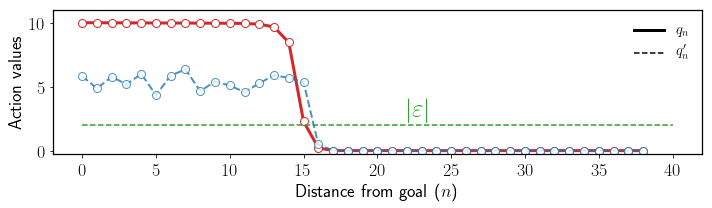

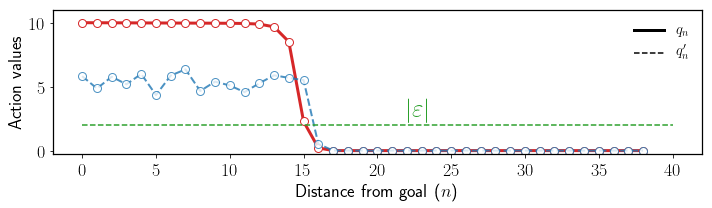

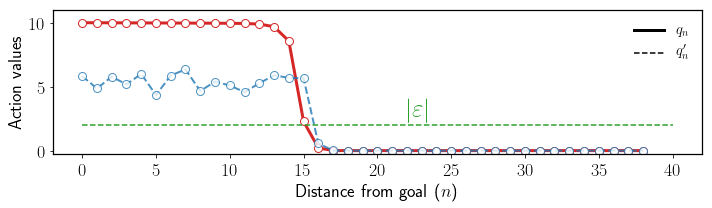

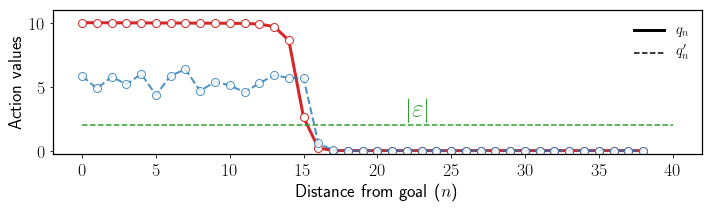

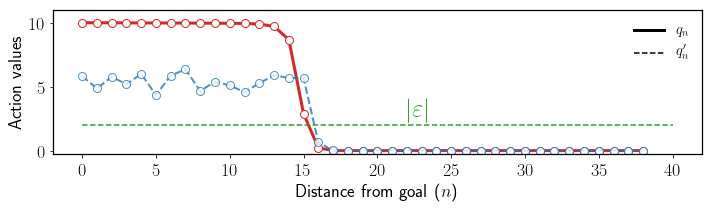

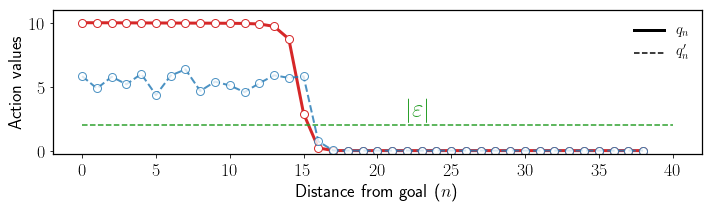

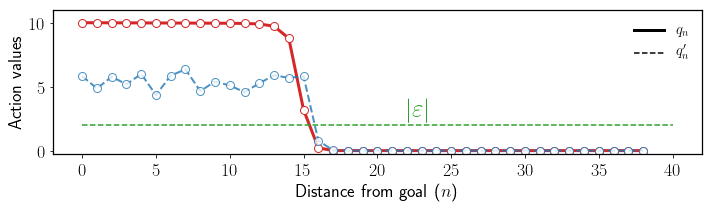

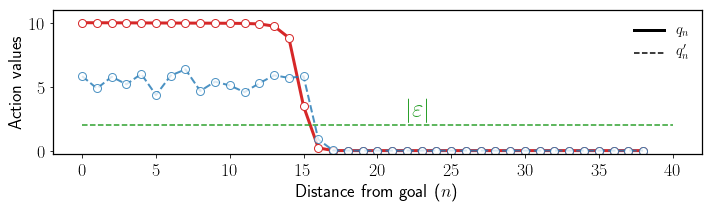

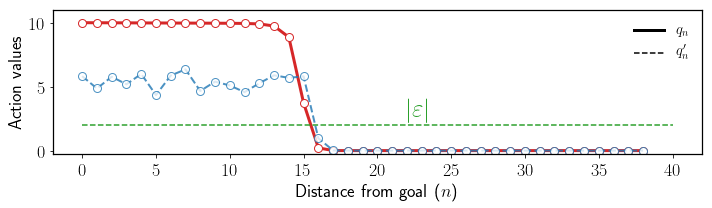

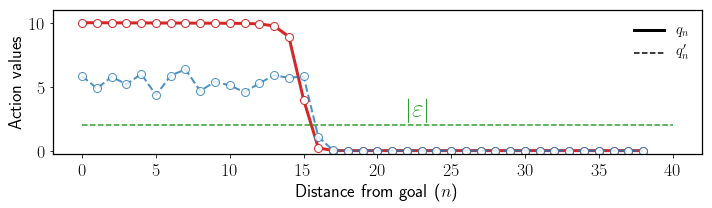

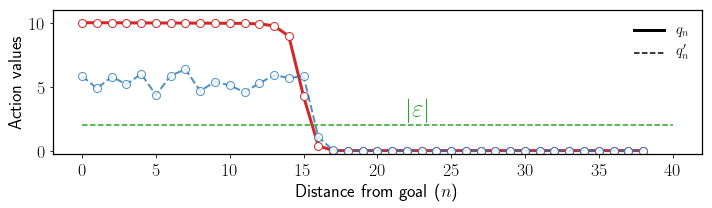

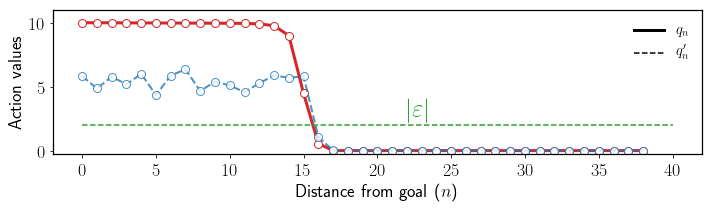

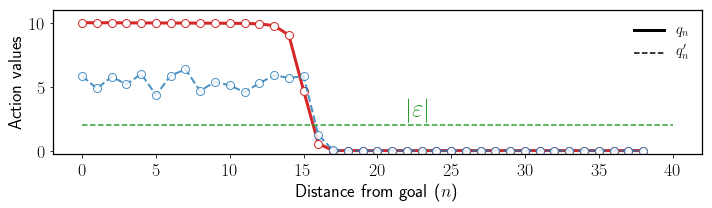

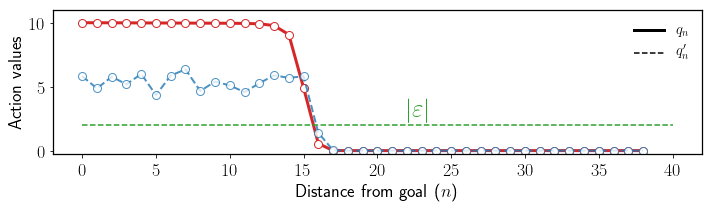

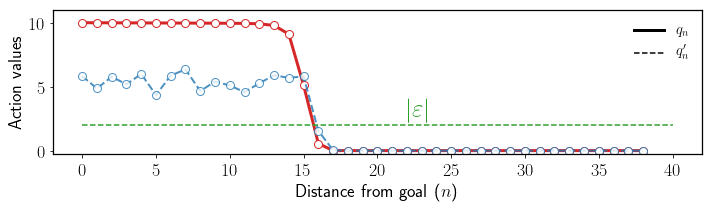

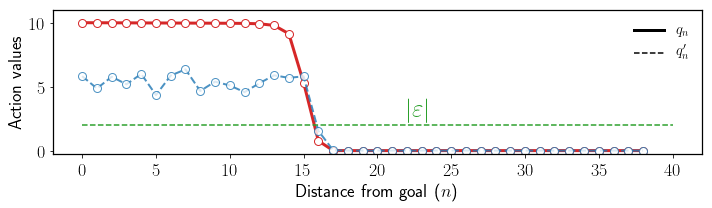

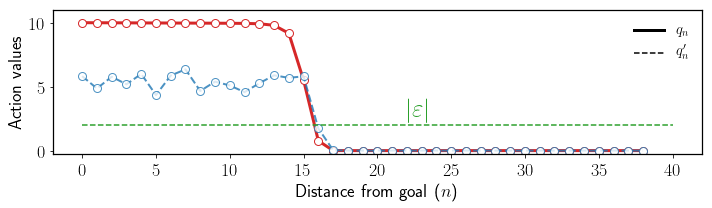

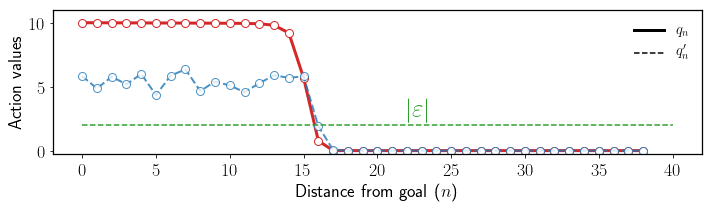

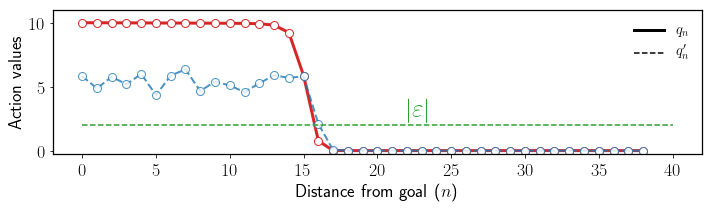

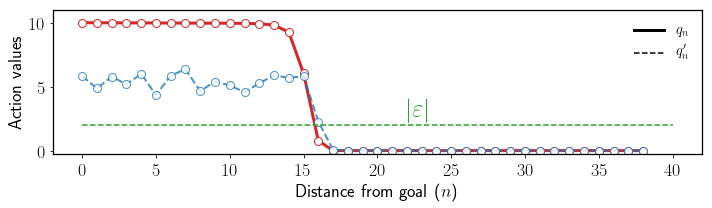

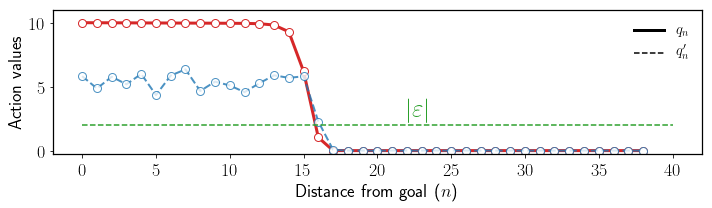

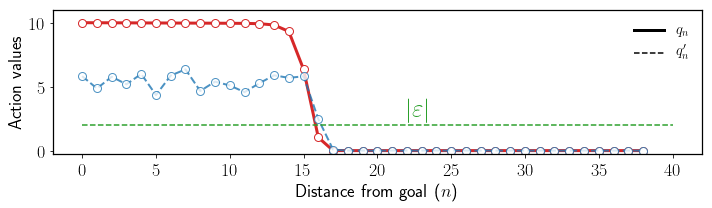

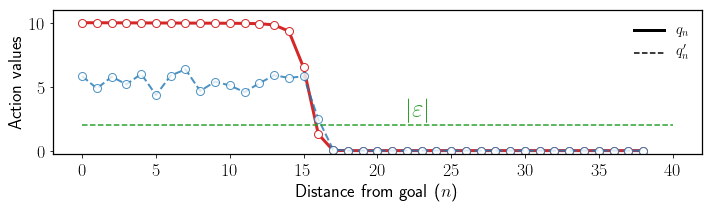

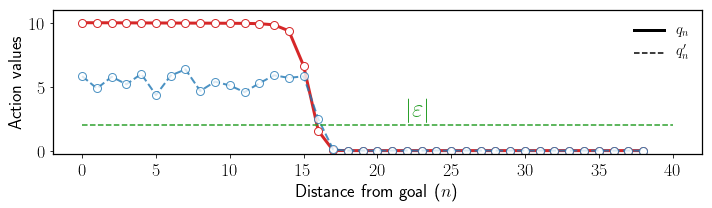

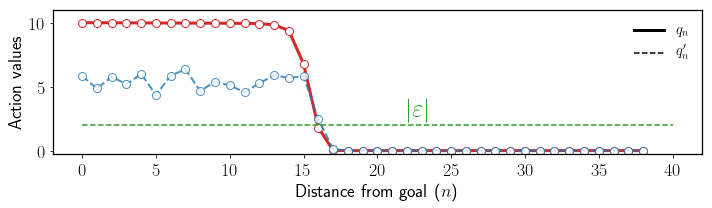

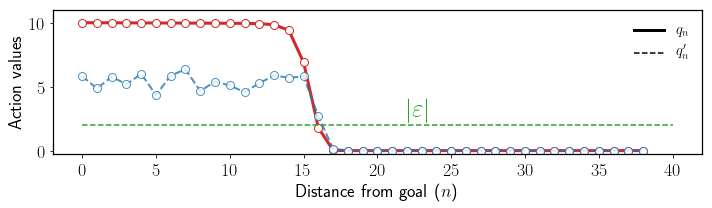

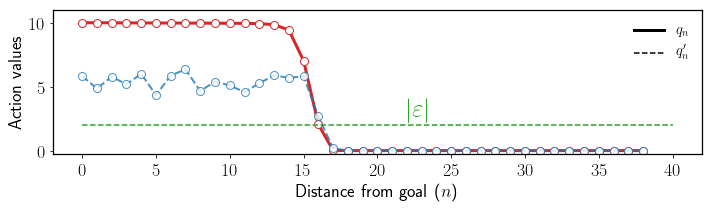

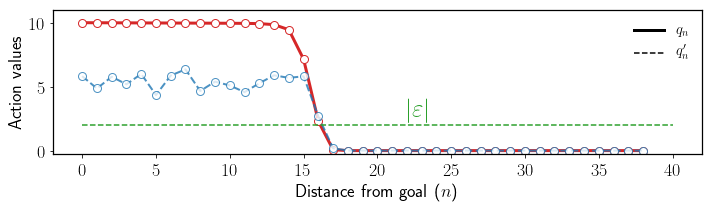

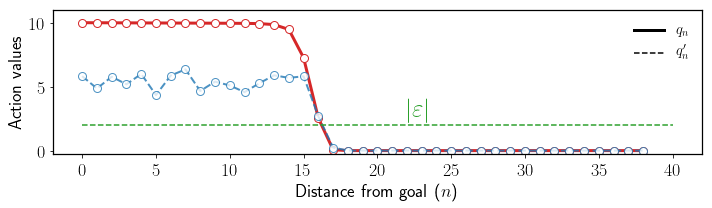

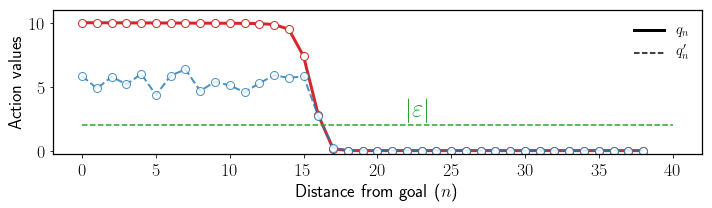

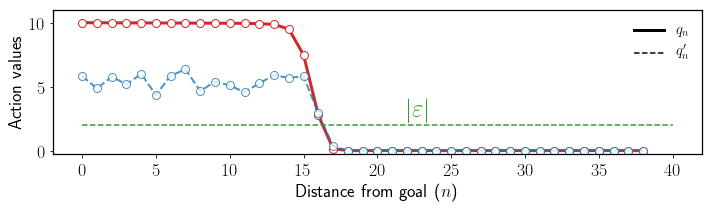

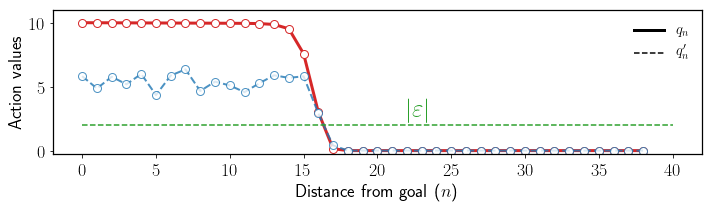

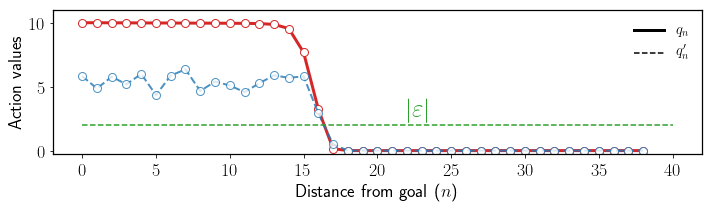

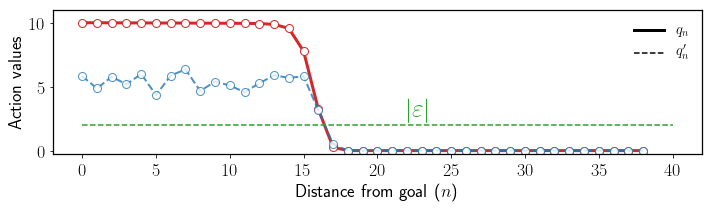

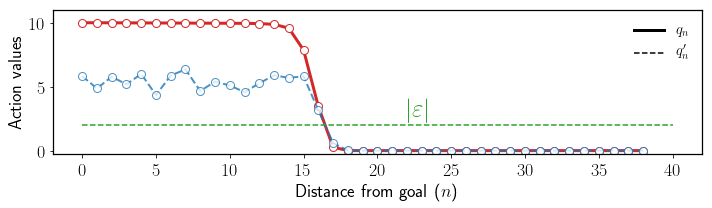

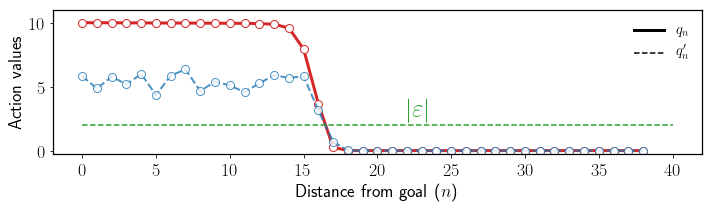

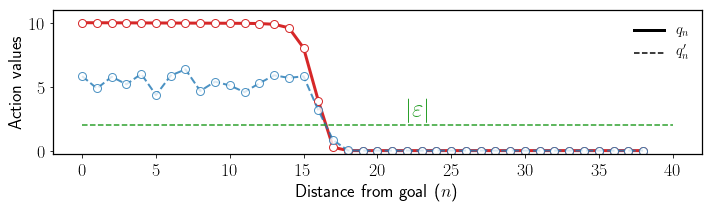

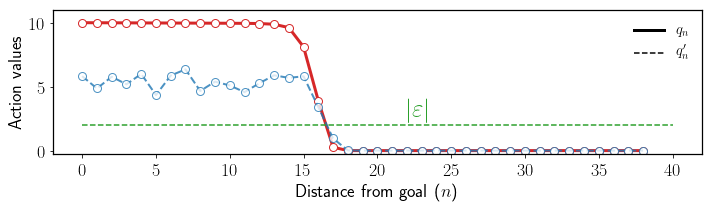

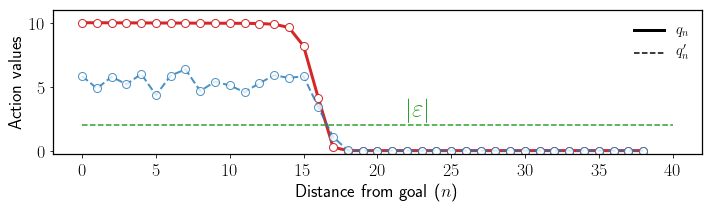

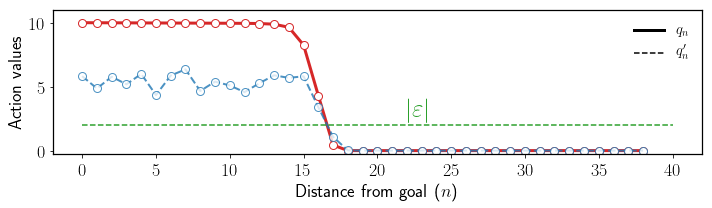

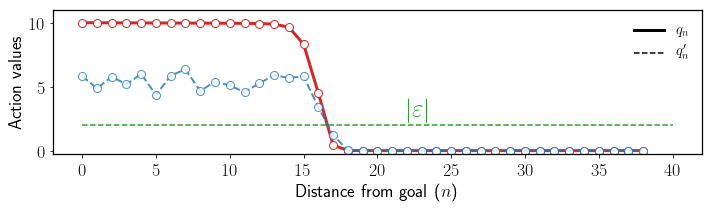

In [200]:
start = 500
for j in range(0,140,1):#range(1,len(Qrs),2):
    i = j + start
    plt.close("all")
    fig = plt.figure(figsize = (10,3))
    axis = fig.add_subplot(111)

    #axis

    axis.plot(Qrs[i,-1::-1,0,0],'C3o-',lw = 3,ms = 8, mec='C3',mfc = 'w')
    axis.plot(Qrs[i,-1::-1,1,1], 'C0o--', lw = 2,ms = 8,mec='C0',mfc = 'w',alpha = 0.8)
    axis.plot([],[],'k-',lw=3,label = r"$q_n$")
    axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
    axis.legend(fontsize = 15,frameon=False, loc = 1)
    
    axis.plot([0,L],[np.abs(eps), np.abs(eps)],'C2--', lw = 1.5)

    #axis.set_title("Episode: %d"%i,fontsize= 15)
    axis.tick_params(labelsize = 18)
    axis.set_ylim(-0.25,np.max(Qrs)*1.1)
    axis.set_xlabel(r"Distance from goal ($n$)",fontsize = 18)
    axis.set_ylabel(r"Action values",fontsize= 18)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.25)
        
    axis.text(22,np.abs(eps)+0.7,r"$|\varepsilon|$", fontsize = 25, color= 'C2')

    fig.tight_layout()
    fig.savefig("./movies/movie_marching_r10_L40_%04d.png"%j, dpi = 150)
    plt.show()

### Measure speed in simulations (placeholder until all simulations are done)

In [197]:
np.random.seed(0)
L = 20
eps2 = 1
r = 10
epss = np.linspace(-4,6,14)
niters = 4
vsarsas = np.zeros((len(epss),niters))

for e,eps in enumerate(epss):
    for n in range(niters):
        vsarsa = get_speed_sarsa(L,eps,eps2,r,alpha = 0.1,plot=False)
        vsarsas[e,n] = vsarsa
    print("%d  %.2f  %.2f %.3f %.3f" %(r,eps,eps2,np.mean(vsarsas[e]), np.std(vsarsas[e])))

10  -4.00  1.00 0.093 0.016
10  -3.23  1.00 0.209 0.017
10  -2.46  1.00 0.351 0.016
10  -1.69  1.00 0.574 0.039
10  -0.92  1.00 0.762 0.004
10  -0.15  1.00 0.876 0.008
10  0.62  1.00 0.939 0.005
10  1.38  1.00 0.967 0.003
10  2.15  1.00 0.981 0.002
10  2.92  1.00 0.986 0.002
10  3.69  1.00 0.991 0.004
10  4.46  1.00 0.994 0.003
10  5.23  1.00 0.990 0.002
10  6.00  1.00 0.992 0.000


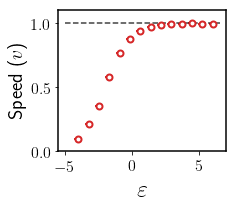

In [202]:
plt.close("all")
fig,axis =plt.subplots(1,1,figsize = (3.5,3))
axis.errorbar(epss,np.mean(vsarsas,axis=1),yerr =np.std(vsarsas,axis=1)/np.sqrt(niter),\
              fmt = 'C3o',ms = 6,mfc = 'w',mew=2,elinewidth = 10, capsize = 4)
axis.plot([-5,6.5],[1,1],'k--',lw=1.5,alpha = 0.75)
axis.set_ylim(0,1.1)
axis.set_xlim(-5.5,7)
axis.tick_params(labelsize = 16)
axis.set_xlabel(r"$\varepsilon$",fontsize = 24)
axis.set_ylabel(r"Speed ($v$)",fontsize = 20)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
fig.tight_layout()
fig.savefig("./plots/speed_wave_simulations_only.pdf")
plt.show()

### Compare numerics and simulations

#### eps = -2, eps2 = +5, r = 15, L = 50

In [5]:
np.random.seed(0)
# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
rew = 15
eps = -2
eps2 = 5
eps3 = 0
L = 50 #length of track
lamb = 0.0 #eligibility traces

pp = sig(eps) + (1-sig(eps))*sig(eps2)
pn = sig(eps3) + (1-sig(eps3))*(1-sig(eps2))
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,plot = False)
print("%.2f  %.2f   %.2f   %.2f   %.2f   %.2f" %(eps,eps2,eps3, pp, pn, vnum))

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(4*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                    alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2)

nepi = len(Qrs)
print(nepi)
mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
vsim = -p[0]/alpha

#Prediction from numerics as a consistency check
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,plot = False)
print("nepi: %d  vsim:  %.2f  vnum:  %.2f "%(nepi, vsim, vnum))

-2.00  5.00   0.00   0.99   0.50   0.63
1608
nepi: 1608  vsim:  0.61  vnum:  0.63 


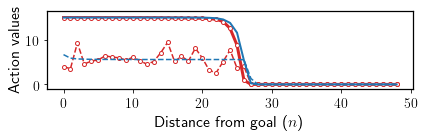

In [7]:
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
eps3 = G['1']['0']['Qe'][0]

r = rew
N = nepi

qs,ss = get_qs_numerics(r,L,N,eps,eps2, alpha = alpha)
#print(alpha,r,L,N,eps,eps2)
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,2))
epis = [int(42/alpha)]
colors_Q = ['C3']
colors_q = ['C0']
alphas = [1.0]
locs = [5.5]

for i,e in enumerate(epis):
    axis.plot(Qrs[e,-1::-1,0,0],'o-',lw = 3,ms = 4, mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    axis.plot(Qrs[e,-1::-1,1,1], 'o--', lw = 1.5,ms = 4,mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    #axis.text(locs[i],rew/2,r"$t = %d$"%(e*alpha),color = colors[i],fontsize = 15)
    axis.plot(qs[-2::-1,e],'-', lw = 2, color = colors_q[i])
    axis.plot(ss[-2::-1,e], '--',lw = 1.5, color = colors_q[i])
    
axis.plot([],[],'k-',lw=3,label = r"$q_n$")
axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
axis.plot([],[],'C3-',lw=1.5,label = "simulations")
axis.plot([],[],'C0-',lw=1.5,label = "eq.2")
#axis.legend(fontsize = 12,frameon=False)

#axis.set_title("Episode: %d"%i,fontsize= 15)
axis.tick_params(labelsize = 14)
axis.set_ylim(-1,np.max(Qrs)*1.1)
#axis.set_xticks([])
axis.set_xlabel(r"Distance from goal ($n$)",fontsize = 16)
axis.set_ylabel(r"Action values",fontsize= 16)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
fig.tight_layout()
fig.savefig("./plots/wave_sim_num_eps_m2_eps2_5.pdf")
plt.show()

#### eps = +2, eps2 = +1, r = 15, L = 50 

In [166]:
np.random.seed(0)
# Learning parameters
alpha = 0.05 #learning rate
gam = 0.9999 #discount factor
rew = 15
eps = 2
eps2 = 1
L = 50 #length of track
lamb = 0.0 #eligibility traces

pp = sig(eps) + (1-sig(eps))*sig(eps2)
pn = sig(eps3) + (1-sig(eps3))*(1-sig(eps2))
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,plot = False)
print("%.2f  %.2f   %.2f   %.2f   %.2f   %.2f" %(eps,eps2,eps3, pp, pn, vnum))

niter = 50000 #large enough that agent reaches reward in each episode. 
nepi = int(4*L/alpha) #large enough that learning converges. 
#the simulation automatically stops when the wave reaches the start.

mode = 2

G, Qrs, time_rews, cum_rews = run_RL_simulation(nepi,niter,L,lamb = lamb,\
                                    alpha = alpha,gam=gam,rew = rew,mode=mode, eps=eps,eps2=eps2)

nepi = len(Qrs)
print(nepi)
mins = np.argmin(np.abs(Qrs[int(0.1*nepi):,:,0,0] - np.max(Qrs[int(0.1*nepi):,:,0,0],axis=1)[:,None]/2),axis=1)
p = np.polyfit(np.arange(len(mins[1:])),mins[1:],1)
vsim = -p[0]/alpha

#Prediction from numerics as a consistency check
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
vnum = get_speed_numerics(L,eps,eps2,rew, alpha = alpha, gam = gam,plot = False)
print("nepi: %d  vsim:  %.2f  vnum:  %.2f "%(nepi, vsim, vnum))

2.00  1.00   0.00   0.97   0.63   0.99
983
nepi: 983  vsim:  0.99  vnum:  0.99 


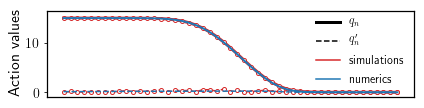

In [168]:
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
eps3 = G['1']['0']['Qe'][0]

r = rew
N = nepi

qs,ss = get_qs_numerics(r,L,N,eps,eps2, alpha = alpha)
#print(alpha,r,L,N,eps,eps2)
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,1.6))
epis = [int(26/alpha)]
colors_Q = ['C3']
colors_q = ['C0']
alphas = [1.0]
locs = [5.5]

for i,e in enumerate(epis):
    axis.plot(Qrs[e,-1::-1,0,0],'o-',lw = 3,ms = 4, mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    axis.plot(Qrs[e,-1::-1,1,1], 'o--', lw = 1.5,ms = 4,mec=colors_Q[i],mfc = 'w', color = colors_Q[i],alpha = alphas[i])
    #axis.text(locs[i],rew/2,r"$t = %d$"%(e*alpha),color = colors[i],fontsize = 15)
    axis.plot(qs[-2::-1,e],'-', lw = 2, color = colors_q[i])
    axis.plot(ss[-2::-1,e], '--',lw = 1.5, color = colors_q[i])
    
axis.plot([],[],'k-',lw=3,label = r"$q_n$")
axis.plot([],[],'k--',lw=1.5,label = r"$q_n'$")
axis.plot([],[],'C3-',lw=1.5,label = "simulations")
axis.plot([],[],'C0-',lw=1.5,label = "numerics")
axis.legend(fontsize = 12,frameon=False)

#axis.set_title("Episode: %d"%i,fontsize= 15)
axis.tick_params(labelsize = 14)
axis.set_ylim(-1,np.max(Qrs)*1.1)
axis.set_xticks([])
#axis.set_xlabel(r"Distance from start ($n$)",fontsize = 16)
axis.set_ylabel(r"Action values",fontsize= 16)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
fig.tight_layout()
fig.savefig("./plots/wave_sim_num_eps_2_eps2_1.pdf")
plt.show()

#### Compare simulations and numerics by episode (not used to generate figures) 

-2.0 5.0


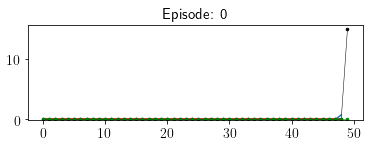

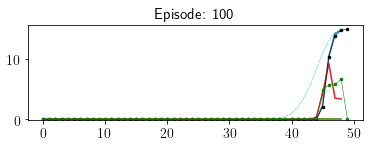

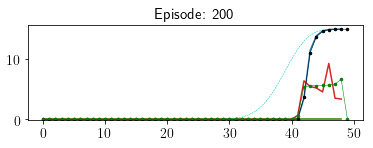

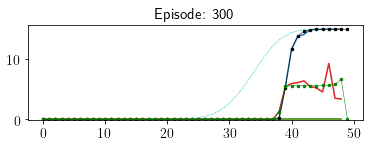

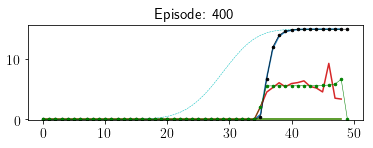

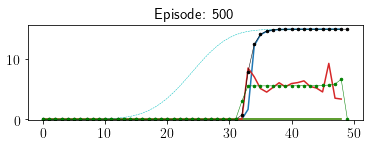

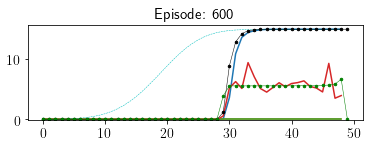

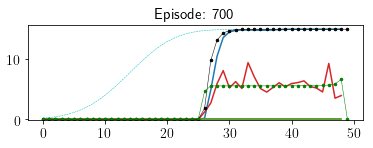

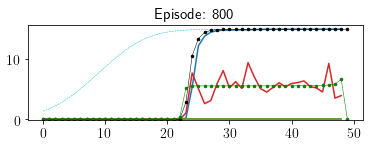

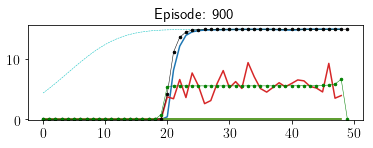

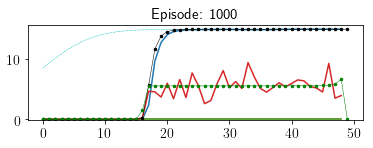

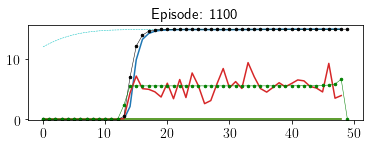

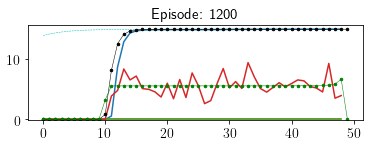

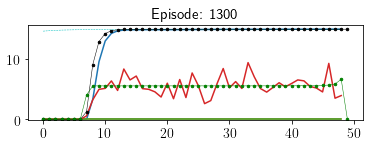

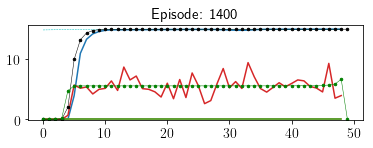

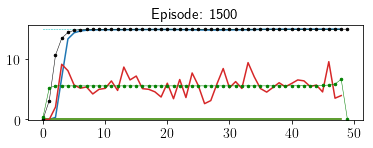

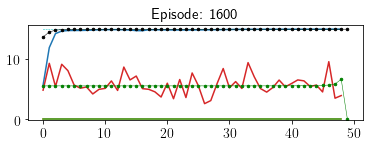

In [9]:
eps = G['0']['1']['Qe'][0]
eps2 = -G['1b']['1']['Qe'][0]
print(eps,eps2)
r = rew
N = nepi

qs,ss = get_qs_numerics(r,L,N,eps,eps2, alpha = alpha)

for i in np.arange(0,nepi,100):
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (6,1.75))
    axis.plot(Qrs[i,:,:,0])
    axis.plot(Qrs[i,:,:,1])
    arr = L-np.arange(L-1)-1
    axis.plot((gam**arr)*rew*gammainc(arr,alpha*i),'c--', lw = 0.5)
    plt.plot(qs[:,i],'ko-',ms=2.5,lw=0.5)
    plt.plot(ss[:,i],'go-',ms=2.5,lw=0.5)
    axis.set_title("Episode: %d"%i,fontsize= 15)
    axis.tick_params(labelsize = 14)
    axis.set_ylim(0-0.05,np.max(Qrs)*1.05)
    plt.show()

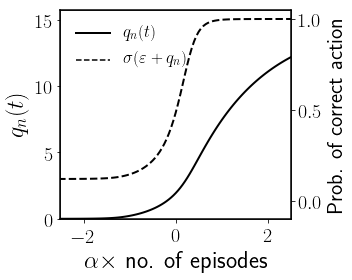

In [125]:
r = 15
L = 50
nepi = int(6*L/alpha)
N = nepi

eps2 = 5
alpha = 0.05

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (5,4))
ax = axis.twinx()
epss = [-2]
ind = 2
for i,eps in enumerate(epss):
    qs,ss = get_qs_numerics(r,L,N,eps,eps2, alpha = alpha)
    minner = np.argmin(np.abs(qs[ind,:] + eps))
    axis.plot((np.arange(N)-minner)*alpha,qs[ind,:],'k-',lw = 2, label = r"$q_{n}(t)$")
    #axis.plot([-10,10],[np.abs(eps),np.abs(eps)],'r--',lw = 1,label = r"$|\varepsilon|$")
    axis.plot([],[],'k--', label = r"$\sigma(\varepsilon + q_n)$")
    
    ax.plot((np.arange(N)-minner)*alpha,sig(qs[ind,:]+eps),'k--',lw = 2)
    
axis.set_xlim(-50*alpha,50*alpha)
axis.set_ylim(0,r*1.05)
axis.set_xlabel(r"$\alpha \times $ no. of episodes", fontsize = 24)
axis.set_ylabel(r"$q_n(t)$", fontsize = 24)
ax.set_ylabel("Prob. of correct action", fontsize = 22)
axis.legend(loc = 2, fontsize = 17, frameon = False)
axis.tick_params(labelsize = 20)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
    
ax.set_ylim(-0.1,1.05)
ax.tick_params(labelsize = 20)
ax.set_yticks([0,0.5,1])
fig.tight_layout()
fig.savefig("./Plots/q_vs_time_eps_m2.pdf")
plt.show()

### Compute speed from RL simulations 

In [233]:
np.random.seed(0)

L = 25

eps2s = [1,1,1,2]
rs = [10,25,50,10]


epss = np.linspace(-4,6,12)
niters = 1

vsarsas = np.zeros((len(rs),len(epss),niters))

for i in range(len(rs)):
    r = rs[i]
    eps2 = eps2s[i]
    for e,eps in enumerate(epss):
        for n in range(niters):
            vsarsa = get_speed_sarsa(L,eps,eps2,r,alpha = 0.025,plot=False)
            vsarsas[i,e,n] = vsarsa
        print("%d  %.2f  %.2f %.3f %.3f" %(r,eps,eps2,np.mean(vsarsas[i,e]), np.std(vsarsas[i,e])))

10  -4.00  1.00 0.135 0.000
10  -3.09  1.00 0.246 0.000
10  -2.18  1.00 0.503 0.000
10  -1.27  1.00 0.693 0.000
10  -0.36  1.00 0.845 0.000
10  0.55  1.00 0.932 0.000
10  1.45  1.00 0.968 0.000
10  2.36  1.00 0.986 0.000
10  3.27  1.00 0.992 0.000
10  4.18  1.00 0.996 0.000
10  5.09  1.00 0.997 0.000
10  6.00  1.00 0.998 0.000
25  -4.00  1.00 0.271 0.000
25  -3.09  1.00 0.462 0.000
25  -2.18  1.00 0.709 0.000
25  -1.27  1.00 0.872 0.000
25  -0.36  1.00 0.950 0.000
25  0.55  1.00 0.981 0.000
25  1.45  1.00 0.992 0.000
25  2.36  1.00 0.993 0.000
25  3.27  1.00 0.997 0.000
25  4.18  1.00 0.998 0.000
25  5.09  1.00 0.997 0.000
25  6.00  1.00 0.997 0.000
50  -4.00  1.00 0.375 0.000
50  -3.09  1.00 0.559 0.000
50  -2.18  1.00 0.838 0.000
50  -1.27  1.00 0.945 0.000
50  -0.36  1.00 0.977 0.000
50  0.55  1.00 0.993 0.000
50  1.45  1.00 0.994 0.000
50  2.36  1.00 0.997 0.000
50  3.27  1.00 0.998 0.000
50  4.18  1.00 0.998 0.000
50  5.09  1.00 0.998 0.000
50  6.00  1.00 0.996 0.000
10  -4.00  2.

In [234]:
epss_preds = np.linspace(-6,6,25)

vtheorys = np.zeros((len(rs),len(epss_preds)))
vnums = np.zeros((len(rs),len(epss_preds)))

for i in range(len(rs)):
    r = rs[i]
    eps2 = eps2s[i]
    
    for e,eps in enumerate(epss_preds):
        #vnum = get_speed_numerics(L,eps,eps2,r, alpha = 0.01, gam = gam,plot = False)
        #vnums[i,e] = vnum
        vtheorys[i,e] = min(1,r/(r + np.exp(-eps)-1))

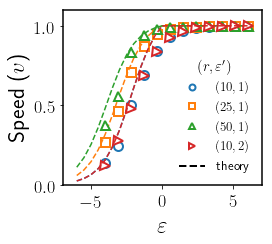

In [237]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (4,3.5))
markers = ['o','s','^','>']
for i in range(len(rs)):
    r = rs[i]
    axis.plot(epss,np.mean(vsarsas[i],axis=-1),'C%d'%i + markers[i]\
              ,ms = 9,mfc = 'w',mew=2)
    axis.plot([],[],'C%d'%i + markers[i]\
              ,ms = 6,mfc = 'w',mew=2, label = r"$(%d,%d)$"%(rs[i],eps2s[i]))
    
    axis.plot(epss_preds, vtheorys[i],'C%d--'%i)
    
axis.plot([],[],'k--', lw = 2, label = "theory")

axis.legend(fontsize = 13, frameon=False, title = r"$(r,\varepsilon')$", title_fontsize = 15)
axis.set_ylim(0,1.1)
axis.set_xlim(-7,7)
axis.tick_params(labelsize = 18)
axis.set_xlabel(r"$\varepsilon$",fontsize = 23)
axis.set_ylabel(r"Speed ($v$)",fontsize = 23)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
fig.tight_layout()
fig.savefig("./plots/speed_sim_theory_match.pdf")
plt.show()

#### Predicted learning curves

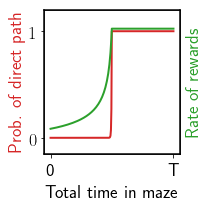

In [540]:
L = 50
u = 0.2 #drift of exploring agent
v = 1 #learning speed

eps = -1

thr = L/v

K = np.arange(0,int(4*thr))
T = np.zeros(len(K))

T = (K < thr)*(K*(L/u - 0.5*v*(K+1)*(1-u)/u)) + (K >= thr)*((thr - 0.5*(thr+1)*(1-u))*L/u + (K-thr)*L)
Tk = (K < thr)*(L/u + v*K*(u-1)/u) + (K >= thr)*L

Pk = (K < thr)*(sig(eps)**(L-v*K)) + (K >= thr)*1

# plt.close("all")
# plt.plot(T,K)
# plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize= (3,3))
axis.plot(T,Pk,'C3',lw= 2)

axis.set_ylim(-0.15,1.2)
axis.tick_params(labelsize = 18)
axis.set_xlabel("Total time in maze",fontsize = 18)
axis.set_ylabel("Prob. of direct path",fontsize = 18, color='C3')
axis.set_xticks([0,T[-1]])
axis.set_xticklabels([0,'T'])
axis.set_yticks([0,1])

ax = axis.twinx()
ax.plot(T,1/Tk,'C2',lw= 2)
ax.set_ylim(0,1.15/Tk[-1])
ax.tick_params(labelsize = 18)
ax.set_ylabel("Rate of rewards",fontsize = 18, color='C2')
ax.set_yticks([])
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
fig.tight_layout()
fig.savefig("./plots/learning_curves.pdf")
plt.show()

#### Plot different regimes of the search:
#### The numerical model is used to compute speed rather simulate over a large range of parameters

In [238]:
pp,pn = get_pp_pn(-4,1,0)
print(pp,pn)

0.735895815502269 0.6344707106849976


In [239]:
eps3 = 0 #eps3 is fixed to 0
L = 25
r = 12

epss = np.linspace(-5,5,80)
eps2s = np.linspace(-5,5,80)

stallmap = np.zeros((len(epss),len(eps2s)))
wavemap = np.zeros((len(epss),len(eps2s)))

for e,eps in enumerate(epss):
    if e%10==0:
        print(e,eps)
    for e2,eps2 in enumerate(eps2s):
        pp,pn = get_pp_pn(eps,eps2,eps3)
        stallmap[e,e2] = (pn > pp)
        if pp >= pn:
            vnum = get_speed_numerics(L,eps,eps2,r, alpha = 0.1,plot = False)
            wavemap[e,e2] = vnum
            

0 -5.0
10 -3.7341772151898733
20 -2.4683544303797467
30 -1.20253164556962
40 0.06329113924050667
50 1.3291139240506329
60 2.59493670886076
70 3.860759493670887


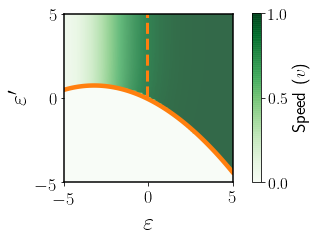

In [242]:
#embarrassingly complex method to plot the different regimes

thr = 0.95
bd_es = []
bd_e2s = []
for e2 in range(len(eps2s)):
    e = np.max(np.arange(len(epss))[wavemap[:,e2] < thr])
    e = np.argmin(np.abs(epss))
    if stallmap[e,e2] < 0.1:
        bd_es += [epss[e]]
        bd_e2s += [eps2s[e2]]
bd_es = np.array(bd_es)
bd_e2s = np.array(bd_e2s)
        
sd_es = []
sd_e2s = []
for e in range(len(epss)):
    sd_e2s += [eps2s[stallmap[e] < 0.99][0]-0.5*(eps2s[1]-eps2s[0])]
    sd_es += [epss[e]]
sd_es = np.array(sd_es)
sd_e2s = np.array(sd_e2s)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
im = axis.imshow(wavemap.T, origin = "below", interpolation="bilinear", alpha = 0.8,\
            extent = [epss[0],epss[-1],eps2s[0],eps2s[-1]],vmin = 0, vmax = 1, cmap = "Greens")

cb = plt.colorbar(im, orientation="vertical", pad=0.1, fraction =0.043, alpha = 0.8)
cb.ax.tick_params(labelsize = 16)
cb.set_ticks([0,0.5,1])
cb.set_label(r"Speed ($v$)", fontsize = 18)

p = np.polyfit(bd_e2s, bd_es,3)
pred3 = p[0]*bd_e2s**3 + p[1]*bd_e2s**2 + p[2]*bd_e2s**1 + p[3]
axis.plot(pred3,bd_e2s,'C1--',lw=3,alpha = 1)

p = np.polyfit(sd_es, sd_e2s,3)
pred3 = p[0]*sd_es**3 + p[1]*sd_es**2 + p[2]*sd_es**1 + p[3]
axis.plot(sd_es,pred3, 'C1',lw = 4.5,alpha = 1)

axis.tick_params(labelsize= 18)
axis.set_xticks([epss[0],0,epss[-1]])
axis.set_yticks([eps2s[0],0,eps2s[-1]])
axis.set_ylabel(r"$\varepsilon'$", fontsize = 24)
axis.set_xlabel(r"$\varepsilon$", fontsize = 24)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
    
fig.tight_layout()
fig.savefig("./plots/learning_regimes.pdf")
plt.show()

#### Measure shape of wavefront 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


1
11
21


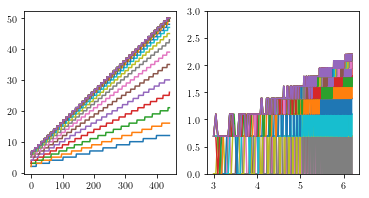

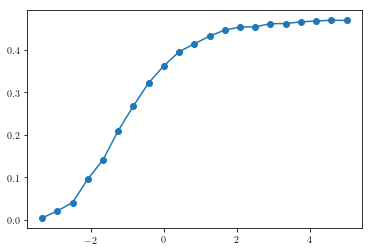

In [834]:
r = 50
L = 3000
eps2 = 2

eps3 = 0
alpha= 0.1

epss = np.linspace(-5,5,25)
#epss = [10]


plt.close("all")
fig,axis = plt.subplots(1,2,figsize = (6,3))

tmax = 1000
ts = np.arange(50,tmax)

powers = np.zeros(len(epss))

for i,eps in enumerate(epss):
    if i%10==1:
        print(i)
    pp,pn = get_pp_pn(eps,eps2,eps3)

    qs,ss = get_qs_numerics(r,L,N,eps,eps2, alpha = alpha)

    pp50 = np.argmin(np.abs(qs - np.max(qs,axis=0)[None,:]/2),axis=0)
    pp90 = np.argmin(np.abs(qs - np.max(qs,axis=0)[None,:]*0.9),axis=0)
    pp10 = np.argmin(np.abs(qs - np.max(qs,axis=0)[None,:]*0.1),axis=0)
    axis[0].plot(L-pp50[50:tmax])
    
    tmin = 20
    logdiff = np.log(pp50[tmin:tmax]-pp10[tmin:tmax])
    logt = np.log(np.arange(tmin,len(logdiff)+tmin))
    axis[1].plot(logt,logdiff)
    axis[1].set_ylim(0,3)
    
    p = np.polyfit(logt, logdiff,1)
    #print("%.2f  %.2f  %.2f  %.2f" %(eps, pp,pn,p[0]))
    powers[i] = p[0]
plt.show()

plt.close("all")
plt.plot(epss,powers,'o-')
plt.show()

#### Verify first passage time calculation

In [382]:
def fp_pred(L,pp,pn): #pred
    if pn == pp:
        return ((2-pp - pn)/pp)*(L*(L+1)/2 + L)
    fac = (2- pp - pn)/(pp-pn)
    fac2 = 2*(1-pp)/(pn - pp)
    fac3 = fac2*(pn*((pn/pp)**(L+1) - 1)/(pn - pp)) + fac*(L+1)
    return fac3

def ru(p): 
    return np.random.uniform() < p

L = 8
pp = 0.85
pn = 0.25

nsims = 10000
maxiter = 100000
ts = np.zeros(nsims)

for i in range(nsims):
    a = 1
    x = 0
    for n in range(maxiter):
        if x == L + 1:
            ts[i] = n
            break
        
        if x < 0 and a == 0:
            x = 0
            a = 1
            
        if a == 1: 
            if ru(pp):
                x += 1
            else:
                a = 1-a
        else:
            if ru(pn):
                x -= 1
            else:
                a = 1-a

print(np.mean(ts))
print(fp_pred(L,pp,pn))

13.2648
13.291670097886229
